In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
import gzip
import requests
from collections import OrderedDict
import pickle

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(42)

#아래 함수가 작도되지 않을때 사용 x의 shape이 다릅니다.
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()



def download_file(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

def load_mnist(kind='train'):
    base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com"
    file_dict = {
        'train': ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz'],
        'test': ['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
    }

    images_file, labels_file = file_dict[kind]

    # 이미지 파일 확인 및 다운로드
    if not os.path.exists(images_file):
        download_file(os.path.join(base_url, images_file), images_file)
    with gzip.open(images_file, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(-1, 784)

    # 레이블 파일 확인 및 다운로드
    if not os.path.exists(labels_file):
        download_file(os.path.join(base_url, labels_file), labels_file)
    with gzip.open(labels_file, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    return images, labels
#정규화
def normalization(x_train,x_test):
  x_train = x_train.astype(np.float32) / 255.0
  x_test = x_test.astype(np.float32) / 255.0
#원핫 인코딩
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((labels.shape[0], num_classes))
    for i, label in enumerate(labels):
        one_hot[i, label] = 1.0
    return one_hot
#무작위 섞기
def shuffle_data(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    return x[indices], y[indices]

간단한 분석


(60000, 784)


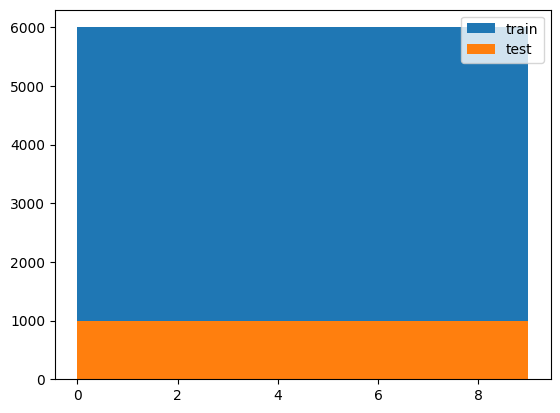

In [14]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
#x_train, y_train = load_mnist(kind='train')
#x_test, y_test = load_mnist(kind='test')
print(x_train.shape)
plt.hist(y_train,label="train")
plt.hist(y_test,label='test')
plt.legend()
plt.show()

## 전처리

In [15]:
#정규화
normalization(x_train,x_test)
#셔플(1에폭 마다 실행하는걸로 수정했습니다.)
x_train, y_train = shuffle_data(x_train, y_train)
#원핫 인코딩
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

## Function

In [16]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)



## Layers

In [17]:
# coding: utf-8
import numpy as np

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None  # 손실함수
        self.y = None     # softmax의 출력
        self.t = None     # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        if t.ndim == 2:  # if t is one-hot encoded
            t = t.argmax(axis=1)

        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx


## Optimizer

In [18]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

## Gradient

In [19]:
def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()

    return grad

## Trainer

## Multilayer

In [20]:
# class MultiLayerNet:
#     def __init__(self, layer_sizes, weight_init_std=0.01, use_dropout=False, dropout_ratio=0.5, use_batchnorm=False):
#         self.params = {}
#         self.layers = OrderedDict()
#         self.use_dropout = use_dropout
#         self.use_batchnorm = use_batchnorm
#         self.dropout_ratio = dropout_ratio

#         num_layers = len(layer_sizes)
#         for i in range(1, num_layers):
#             #std
#             #self.params['W' + str(i)] = weight_init_std * np.random.randn(layer_sizes[i-1], layer_sizes[i])
#             #HE

#             self.params['b' + str(i)] = np.zeros(layer_sizes[i])

#             self.layers['Affine' + str(i)] = Affine(self.params['W' + str(i)], self.params['b' + str(i)])

#             if use_batchnorm and i < num_layers - 1:  # 마지막 레이어 전까지만 배치 정규화 적용
#                 self.params['gamma' + str(i)] = np.ones(layer_sizes[i])
#                 self.params['beta' + str(i)] = np.zeros(layer_sizes[i])
#                 self.layers['BatchNorm' + str(i)] = BatchNormalization(self.params['gamma' + str(i)], self.params['beta' + str(i)])

#             if i < num_layers - 1:  # 마지막 레이어 전까지만 ReLU 적용
#                 self.layers['Relu' + str(i)] = Relu()
#                 if use_dropout:  # 드롭아웃 적용
#                     self.layers['Dropout' + str(i)] = Dropout(dropout_ratio)

#         self.lastLayer = SoftmaxWithLoss()

#     def predict(self, x):
#         for layer in self.layers.values():
#             x = layer.forward(x)
#         return x

#     def loss(self, x, t):
#         y = self.predict(x)
#         return self.lastLayer.forward(y, t)

#     def accuracy(self, x, t):
#         y = self.predict(x)

#         y = np.argmax(y, axis=1)
#         if t.ndim != 1: t = np.argmax(t, axis=1)
#         accuracy = np.sum(y == t) / float(x.shape[0])
#         return accuracy

#     def accuracy_per_class(self, X, Y):
#         predictions = self.predict(X)
#         true_labels = np.argmax(Y, axis=1)
#         unique_labels = np.unique(true_labels)

#         accuracy = {}
#         for label in unique_labels:
#             idx = true_labels == label
#             accuracy[label] = np.sum(predictions[idx] == true_labels[idx]) / np.sum(idx)

#         return accuracy

#     def numerical_gradient(self, x, t):
#         loss_W = lambda W: self.loss(x, t)
#         grads = {}
#         for idx, key in enumerate(self.params):
#             grads[key] = numerical_gradient(loss_W, self.params[key])
#         return grads


#     def gradient(self, x, t):
#         # 순전파
#         self.loss(x, t)

#         # 역전파
#         dout = 1
#         dout = self.lastLayer.backward(dout)

#         layers = list(self.layers.values())
#         layers.reverse()
#         for layer in layers:
#             dout = layer.backward(dout)

#         # 결과 저장
#         grads = {}
#         affine_idx = 1  # Affine 레이어에 대한 인덱스를 추적합니다.
#         for key, layer in self.layers.items():
#             if 'Affine' in key:
#                 grads['W' + str(affine_idx)] = layer.dW
#                 grads['b' + str(affine_idx)] = layer.db
#                 affine_idx += 1  # 다음 Affine 레이어로 인덱스를 증가시킵니다.

#             if 'BatchNorm' in key and self.use_batchnorm and affine_idx > 1:  # 첫 번째 레이어는 BatchNorm 레이어가 아닙니다.
#                 grads['gamma' + str(affine_idx - 1)] = layer.dgamma
#                 grads['beta' + str(affine_idx - 1)] = layer.dbeta

#         return grads



# network = MultiLayerNet([784, 100, 50, 10])
# print(network.params.keys())
# x = np.random.rand(100, 784)  # 100개의 데이터를 무작위로 생성
# t = np.random.rand(100, 10)   # 100개의 레이블을 무작위로 생성

# # 그래디언트 계산
# grads = network.gradient(x, t)

# # 그래디언트의 키 출력
# print(grads.keys())

## 멀티레이어 확장

In [21]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict


class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads


네트워크 및 하이퍼 파리미터 특이사항

In [22]:
#은닉층이 5개 이상 쌓이면 업데이트가 잘 안됩니다.(그래디언트 소실 발생 예상)
'''
network = MultiLayerNet([784, 128, 64, 32, 16, 10])
100%|██████████| 1/1 [00:03<00:00,  3.82s/it]
epoch 1 |	 Train loss: 2.3026  train acc: 0.1017 test acc: 0.1035
100%|██████████| 1/1 [00:05<00:00,  5.14s/it]
epoch 2 |	 Train loss: 2.3026  train acc: 0.1015 test acc: 0.1035
100%|██████████| 1/1 [00:04<00:00,  4.73s/it]
epoch 3 |	 Train loss: 2.3026  train acc: 0.1013 test acc: 0.1026
100%|██████████| 1/1 [00:03<00:00,  3.65s/it]
epoch 4 |	 Train loss: 2.3026  train acc: 0.1010 test acc: 0.1015
100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
epoch 5 |	 Train loss: 2.3026  train acc: 0.1008 test acc: 0.1013

network = MultiLayerNet([784, 784//4, 256, 128, 10]), epoch 200 lr 0,01
100%|██████████| 200/200 [31:10<00:00,  9.35s/it] | Train loss: 0.6839 | train acc: 0.7308 | test acc: 0.7238

network = MultiLayerNet([784, 256, 128, 10]), epoch 300 lr 0,01
100%|█████████▉| 299/300 [41:06<00:08,  8.25s/it] | Train loss: 0.4176 | train acc: 0.8465 | test acc: 0.8346
100%|██████████| 300/300 [41:14<00:00,  8.25s/it] | Train loss: 0.4298 | train acc: 0.8467 | test acc: 0.8323

network = MultiLayerNet([784, 256, 128, 10])
learning_rate = 0.001
epochs = 1221
 24%|██▍       | 1221/5000 [1:37:08<4:59:19,  4.75s/it] | Train loss: 0.4466 | train acc: 0.8450 | test acc: 0.8336


'''

'\nnetwork = MultiLayerNet([784, 128, 64, 32, 16, 10])\n100%|██████████| 1/1 [00:03<00:00,  3.82s/it]\nepoch 1 |\t Train loss: 2.3026  train acc: 0.1017 test acc: 0.1035\n100%|██████████| 1/1 [00:05<00:00,  5.14s/it]\nepoch 2 |\t Train loss: 2.3026  train acc: 0.1015 test acc: 0.1035\n100%|██████████| 1/1 [00:04<00:00,  4.73s/it]\nepoch 3 |\t Train loss: 2.3026  train acc: 0.1013 test acc: 0.1026\n100%|██████████| 1/1 [00:03<00:00,  3.65s/it]\nepoch 4 |\t Train loss: 2.3026  train acc: 0.1010 test acc: 0.1015\n100%|██████████| 1/1 [00:03<00:00,  3.43s/it]\nepoch 5 |\t Train loss: 2.3026  train acc: 0.1008 test acc: 0.1013\n\nnetwork = MultiLayerNet([784, 784//4, 256, 128, 10]), epoch 200 lr 0,01\n100%|██████████| 200/200 [31:10<00:00,  9.35s/it] | Train loss: 0.6839 | train acc: 0.7308 | test acc: 0.7238\n\nnetwork = MultiLayerNet([784, 256, 128, 10]), epoch 300 lr 0,01\n100%|█████████▉| 299/300 [41:06<00:08,  8.25s/it] | Train loss: 0.4176 | train acc: 0.8465 | test acc: 0.8346\n100%|

## 학습

In [ ]:
import sys
import os
import numpy as np
from tqdm import tqdm


#network = MultiLayerNetExtend(input_size = 784 ,hidden_size_list = [784*2, 784, 256, 64],output_size=10,use_dropout = True, dropout_ration = 0.5, use_batchnorm = True)


'''Network'''
hidden_size = [2048, 1024 ,512, 256]
network = MultiLayerNetExtend(input_size = 784 ,hidden_size_list = hidden_size,output_size=10,use_dropout = True, dropout_ration = 0.5, use_batchnorm = True)
networks = {}
train_loss = {}


'''Hyperparameters'''
iters_num = 1  # 반복횟수
batch_size = int( x_train.shape[0] / iters_num )# 미니배치 크기

best_acc = 0
best_loss = 90.0
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

In [45]:
init_learning_rate = 0.01
epochs = 400
warm_up_ep = 5
optimizer = Adam(lr = init_learning_rate)
learning_rate = 0.001
for epoch in tqdm(range(epochs)):
  # if epoch < warm_up_ep:
  #   learning_rate = round(init_learning_rate*((epoch+1)/warm_up_ep),4)
  # if epoch == 70:
  #   learning_rate = 0.01  
  if epoch == (epochs-100):
    learning_rate = 0.002
    # learning_rate = round(0.01-0.01*((epoch-3)/epochs),4)
  optimizer = Adam(lr = learning_rate)
  # 오차역전파법으로 기울기 계산
  grad = network.gradient(x_train, y_train)
  optimizer.update(network.params, grad)

  loss = network.loss(x_train, y_train)
  train_acc = network.accuracy(x_train, y_train)
  #train기록
  train_loss_list.append(loss)
  train_acc_list.append(train_acc)

  #Vaild
  test_loss = network.loss(x_test, y_test)
  test_acc =network.accuracy(x_test,y_test)
  if test_acc > best_acc:
    best_acc = test_acc
    with open(f'C:\Workspace/SNA/JupyterNotebook/basic_deeplearning/final_project/{hidden_size}.pkl', 'wb') as f:
      pickle.dump(network, f)
  if test_loss < best_loss:
    best_loss = test_loss
  #vaild기록
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

  print(f"Train loss: {loss:.4f}| train acc: {float(train_acc):.4f} | test loss: {float(test_loss):.4f}|test acc: {float(test_acc):.4f}")
print("Best acc:",best_acc,"Best loss:",best_loss)


  0%|          | 1/400 [00:38<4:16:47, 38.62s/it]

Train loss: 0.1918| train acc: 0.9275 | test loss: 0.3240|test acc: 0.8926


  0%|          | 2/400 [01:15<4:10:25, 37.75s/it]

Train loss: 0.1917| train acc: 0.9275 | test loss: 0.3239|test acc: 0.8926


  1%|          | 3/400 [01:52<4:06:15, 37.22s/it]

Train loss: 0.1916| train acc: 0.9275 | test loss: 0.3237|test acc: 0.8926


  1%|          | 4/400 [02:27<4:00:01, 36.37s/it]

Train loss: 0.1915| train acc: 0.9276 | test loss: 0.3238|test acc: 0.8922


  1%|▏         | 5/400 [03:02<3:56:09, 35.87s/it]

Train loss: 0.1915| train acc: 0.9275 | test loss: 0.3237|test acc: 0.8926


  2%|▏         | 6/400 [03:37<3:54:13, 35.67s/it]

Train loss: 0.1915| train acc: 0.9275 | test loss: 0.3239|test acc: 0.8929


  2%|▏         | 7/400 [04:13<3:53:02, 35.58s/it]

Train loss: 0.1914| train acc: 0.9275 | test loss: 0.3239|test acc: 0.8927


  2%|▏         | 8/400 [04:48<3:51:23, 35.42s/it]

Train loss: 0.1913| train acc: 0.9277 | test loss: 0.3240|test acc: 0.8926


  2%|▏         | 9/400 [05:23<3:49:45, 35.26s/it]

Train loss: 0.1913| train acc: 0.9275 | test loss: 0.3239|test acc: 0.8925


  2%|▎         | 10/400 [05:58<3:48:45, 35.19s/it]

Train loss: 0.1912| train acc: 0.9277 | test loss: 0.3239|test acc: 0.8929


  3%|▎         | 11/400 [06:32<3:47:27, 35.08s/it]

Train loss: 0.1911| train acc: 0.9275 | test loss: 0.3238|test acc: 0.8922


  3%|▎         | 12/400 [07:07<3:46:32, 35.03s/it]

Train loss: 0.1911| train acc: 0.9277 | test loss: 0.3238|test acc: 0.8924


  3%|▎         | 13/400 [07:42<3:45:26, 34.95s/it]

Train loss: 0.1910| train acc: 0.9277 | test loss: 0.3239|test acc: 0.8922


  4%|▎         | 14/400 [08:17<3:44:44, 34.93s/it]

Train loss: 0.1909| train acc: 0.9278 | test loss: 0.3239|test acc: 0.8921


  4%|▍         | 15/400 [08:52<3:44:29, 34.98s/it]

Train loss: 0.1908| train acc: 0.9279 | test loss: 0.3240|test acc: 0.8924


  4%|▍         | 16/400 [09:27<3:43:45, 34.96s/it]

Train loss: 0.1909| train acc: 0.9277 | test loss: 0.3238|test acc: 0.8918


  4%|▍         | 17/400 [10:02<3:43:24, 35.00s/it]

Train loss: 0.1908| train acc: 0.9277 | test loss: 0.3238|test acc: 0.8921


  4%|▍         | 18/400 [10:37<3:43:09, 35.05s/it]

Train loss: 0.1908| train acc: 0.9278 | test loss: 0.3238|test acc: 0.8918


  5%|▍         | 19/400 [11:12<3:42:28, 35.03s/it]

Train loss: 0.1907| train acc: 0.9278 | test loss: 0.3238|test acc: 0.8924


  5%|▌         | 20/400 [11:47<3:41:40, 35.00s/it]

Train loss: 0.1906| train acc: 0.9278 | test loss: 0.3239|test acc: 0.8919


  5%|▌         | 21/400 [12:23<3:42:04, 35.16s/it]

Train loss: 0.1905| train acc: 0.9280 | test loss: 0.3240|test acc: 0.8920


  6%|▌         | 22/400 [12:58<3:41:21, 35.14s/it]

Train loss: 0.1905| train acc: 0.9278 | test loss: 0.3239|test acc: 0.8923


  6%|▌         | 23/400 [13:33<3:40:23, 35.08s/it]

Train loss: 0.1904| train acc: 0.9280 | test loss: 0.3241|test acc: 0.8927


  6%|▌         | 24/400 [14:08<3:39:41, 35.06s/it]

Train loss: 0.1903| train acc: 0.9280 | test loss: 0.3240|test acc: 0.8925


  6%|▋         | 25/400 [14:43<3:38:51, 35.02s/it]

Train loss: 0.1903| train acc: 0.9280 | test loss: 0.3242|test acc: 0.8925


  6%|▋         | 26/400 [15:18<3:38:07, 34.99s/it]

Train loss: 0.1902| train acc: 0.9279 | test loss: 0.3241|test acc: 0.8928


  7%|▋         | 27/400 [15:53<3:37:27, 34.98s/it]

Train loss: 0.1902| train acc: 0.9281 | test loss: 0.3240|test acc: 0.8927


  7%|▋         | 28/400 [16:27<3:36:44, 34.96s/it]

Train loss: 0.1901| train acc: 0.9280 | test loss: 0.3238|test acc: 0.8927


  7%|▋         | 29/400 [17:03<3:36:33, 35.02s/it]

Train loss: 0.1901| train acc: 0.9281 | test loss: 0.3240|test acc: 0.8924


  8%|▊         | 30/400 [17:38<3:36:01, 35.03s/it]

Train loss: 0.1900| train acc: 0.9281 | test loss: 0.3240|test acc: 0.8928


  8%|▊         | 31/400 [18:13<3:35:20, 35.01s/it]

Train loss: 0.1900| train acc: 0.9280 | test loss: 0.3241|test acc: 0.8928


  8%|▊         | 32/400 [18:48<3:34:33, 34.98s/it]

Train loss: 0.1899| train acc: 0.9281 | test loss: 0.3241|test acc: 0.8923


  8%|▊         | 33/400 [19:23<3:34:02, 34.99s/it]

Train loss: 0.1899| train acc: 0.9281 | test loss: 0.3239|test acc: 0.8926


  8%|▊         | 34/400 [19:58<3:33:31, 35.00s/it]

Train loss: 0.1898| train acc: 0.9283 | test loss: 0.3239|test acc: 0.8929


  9%|▉         | 35/400 [20:33<3:32:51, 34.99s/it]

Train loss: 0.1897| train acc: 0.9283 | test loss: 0.3240|test acc: 0.8923


  9%|▉         | 36/400 [21:08<3:32:16, 34.99s/it]

Train loss: 0.1897| train acc: 0.9283 | test loss: 0.3240|test acc: 0.8925


  9%|▉         | 37/400 [21:43<3:31:38, 34.98s/it]

Train loss: 0.1895| train acc: 0.9283 | test loss: 0.3241|test acc: 0.8923


 10%|▉         | 38/400 [22:18<3:31:18, 35.02s/it]

Train loss: 0.1894| train acc: 0.9284 | test loss: 0.3241|test acc: 0.8924


 10%|▉         | 39/400 [22:53<3:30:51, 35.05s/it]

Train loss: 0.1894| train acc: 0.9283 | test loss: 0.3240|test acc: 0.8923


 10%|█         | 40/400 [23:28<3:30:25, 35.07s/it]

Train loss: 0.1893| train acc: 0.9283 | test loss: 0.3240|test acc: 0.8925


 10%|█         | 41/400 [24:03<3:30:15, 35.14s/it]

Train loss: 0.1893| train acc: 0.9283 | test loss: 0.3241|test acc: 0.8926


 10%|█         | 42/400 [24:38<3:29:27, 35.11s/it]

Train loss: 0.1893| train acc: 0.9283 | test loss: 0.3241|test acc: 0.8922


 11%|█         | 43/400 [25:13<3:28:36, 35.06s/it]

Train loss: 0.1892| train acc: 0.9283 | test loss: 0.3240|test acc: 0.8920


 11%|█         | 44/400 [25:48<3:27:51, 35.03s/it]

Train loss: 0.1891| train acc: 0.9284 | test loss: 0.3241|test acc: 0.8925


 11%|█▏        | 45/400 [26:23<3:27:10, 35.01s/it]

Train loss: 0.1890| train acc: 0.9284 | test loss: 0.3240|test acc: 0.8927


 12%|█▏        | 46/400 [26:58<3:26:37, 35.02s/it]

Train loss: 0.1890| train acc: 0.9285 | test loss: 0.3242|test acc: 0.8922


 12%|█▏        | 47/400 [27:33<3:25:49, 34.98s/it]

Train loss: 0.1890| train acc: 0.9286 | test loss: 0.3242|test acc: 0.8923


 12%|█▏        | 48/400 [28:08<3:25:08, 34.97s/it]

Train loss: 0.1889| train acc: 0.9284 | test loss: 0.3239|test acc: 0.8923


 12%|█▏        | 49/400 [28:43<3:24:52, 35.02s/it]

Train loss: 0.1888| train acc: 0.9286 | test loss: 0.3240|test acc: 0.8923


 12%|█▎        | 50/400 [29:18<3:24:31, 35.06s/it]

Train loss: 0.1888| train acc: 0.9286 | test loss: 0.3241|test acc: 0.8920


 13%|█▎        | 51/400 [29:53<3:24:10, 35.10s/it]

Train loss: 0.1888| train acc: 0.9286 | test loss: 0.3240|test acc: 0.8921


 13%|█▎        | 52/400 [30:29<3:23:39, 35.11s/it]

Train loss: 0.1887| train acc: 0.9286 | test loss: 0.3242|test acc: 0.8925


 13%|█▎        | 53/400 [31:04<3:22:58, 35.10s/it]

Train loss: 0.1887| train acc: 0.9286 | test loss: 0.3242|test acc: 0.8923


 14%|█▎        | 54/400 [31:39<3:22:08, 35.05s/it]

Train loss: 0.1885| train acc: 0.9287 | test loss: 0.3241|test acc: 0.8922


 14%|█▍        | 55/400 [32:14<3:22:04, 35.14s/it]

Train loss: 0.1885| train acc: 0.9286 | test loss: 0.3239|test acc: 0.8922


 14%|█▍        | 56/400 [32:49<3:21:47, 35.20s/it]

Train loss: 0.1885| train acc: 0.9288 | test loss: 0.3237|test acc: 0.8921


 14%|█▍        | 57/400 [33:24<3:20:49, 35.13s/it]

Train loss: 0.1884| train acc: 0.9290 | test loss: 0.3238|test acc: 0.8922


 14%|█▍        | 58/400 [33:59<3:20:11, 35.12s/it]

Train loss: 0.1884| train acc: 0.9290 | test loss: 0.3239|test acc: 0.8924


 15%|█▍        | 59/400 [34:34<3:19:34, 35.12s/it]

Train loss: 0.1883| train acc: 0.9290 | test loss: 0.3239|test acc: 0.8924


 15%|█▌        | 60/400 [35:09<3:18:43, 35.07s/it]

Train loss: 0.1883| train acc: 0.9290 | test loss: 0.3240|test acc: 0.8925


 15%|█▌        | 61/400 [35:44<3:17:49, 35.01s/it]

Train loss: 0.1882| train acc: 0.9291 | test loss: 0.3240|test acc: 0.8928


 16%|█▌        | 62/400 [36:19<3:17:09, 35.00s/it]

Train loss: 0.1881| train acc: 0.9292 | test loss: 0.3240|test acc: 0.8926


 16%|█▌        | 63/400 [36:55<3:17:03, 35.08s/it]

Train loss: 0.1880| train acc: 0.9291 | test loss: 0.3241|test acc: 0.8926


 16%|█▌        | 64/400 [37:30<3:16:35, 35.11s/it]

Train loss: 0.1879| train acc: 0.9291 | test loss: 0.3239|test acc: 0.8923


 16%|█▋        | 65/400 [38:05<3:15:44, 35.06s/it]

Train loss: 0.1879| train acc: 0.9292 | test loss: 0.3239|test acc: 0.8924


 16%|█▋        | 66/400 [38:44<3:21:46, 36.25s/it]

Train loss: 0.1878| train acc: 0.9293 | test loss: 0.3239|test acc: 0.8931


 17%|█▋        | 67/400 [39:19<3:19:55, 36.02s/it]

Train loss: 0.1878| train acc: 0.9291 | test loss: 0.3240|test acc: 0.8924


 17%|█▋        | 68/400 [39:54<3:17:32, 35.70s/it]

Train loss: 0.1878| train acc: 0.9293 | test loss: 0.3240|test acc: 0.8926


 17%|█▋        | 69/400 [40:29<3:15:38, 35.46s/it]

Train loss: 0.1878| train acc: 0.9293 | test loss: 0.3239|test acc: 0.8926


 18%|█▊        | 70/400 [41:04<3:14:07, 35.29s/it]

Train loss: 0.1877| train acc: 0.9291 | test loss: 0.3242|test acc: 0.8929


 18%|█▊        | 71/400 [41:39<3:13:07, 35.22s/it]

Train loss: 0.1876| train acc: 0.9293 | test loss: 0.3243|test acc: 0.8927


 18%|█▊        | 72/400 [42:14<3:12:06, 35.14s/it]

Train loss: 0.1875| train acc: 0.9292 | test loss: 0.3242|test acc: 0.8925


 18%|█▊        | 73/400 [42:49<3:11:02, 35.05s/it]

Train loss: 0.1875| train acc: 0.9292 | test loss: 0.3241|test acc: 0.8925


 18%|█▊        | 74/400 [43:24<3:10:47, 35.12s/it]

Train loss: 0.1875| train acc: 0.9293 | test loss: 0.3241|test acc: 0.8927


 19%|█▉        | 75/400 [43:59<3:10:22, 35.14s/it]

Train loss: 0.1874| train acc: 0.9293 | test loss: 0.3241|test acc: 0.8928


 19%|█▉        | 76/400 [44:35<3:09:59, 35.18s/it]

Train loss: 0.1873| train acc: 0.9294 | test loss: 0.3241|test acc: 0.8925


 19%|█▉        | 77/400 [45:10<3:09:11, 35.14s/it]

Train loss: 0.1874| train acc: 0.9295 | test loss: 0.3240|test acc: 0.8924


 20%|█▉        | 78/400 [45:44<3:07:55, 35.02s/it]

Train loss: 0.1872| train acc: 0.9294 | test loss: 0.3243|test acc: 0.8921


 20%|█▉        | 79/400 [46:19<3:07:20, 35.02s/it]

Train loss: 0.1872| train acc: 0.9294 | test loss: 0.3242|test acc: 0.8918


 20%|██        | 80/400 [46:54<3:06:44, 35.01s/it]

Train loss: 0.1871| train acc: 0.9294 | test loss: 0.3243|test acc: 0.8920


 20%|██        | 81/400 [47:29<3:05:51, 34.96s/it]

Train loss: 0.1871| train acc: 0.9294 | test loss: 0.3241|test acc: 0.8925


 20%|██        | 82/400 [48:04<3:05:14, 34.95s/it]

Train loss: 0.1870| train acc: 0.9295 | test loss: 0.3240|test acc: 0.8929


 21%|██        | 83/400 [48:39<3:04:36, 34.94s/it]

Train loss: 0.1870| train acc: 0.9295 | test loss: 0.3238|test acc: 0.8927


 21%|██        | 84/400 [49:14<3:04:00, 34.94s/it]

Train loss: 0.1869| train acc: 0.9295 | test loss: 0.3237|test acc: 0.8925


 21%|██▏       | 85/400 [49:49<3:03:27, 34.95s/it]

Train loss: 0.1869| train acc: 0.9295 | test loss: 0.3235|test acc: 0.8929


 22%|██▏       | 86/400 [50:24<3:02:57, 34.96s/it]

Train loss: 0.1869| train acc: 0.9296 | test loss: 0.3235|test acc: 0.8927


 22%|██▏       | 87/400 [50:59<3:02:34, 35.00s/it]

Train loss: 0.1868| train acc: 0.9296 | test loss: 0.3234|test acc: 0.8931


 22%|██▏       | 88/400 [51:34<3:02:18, 35.06s/it]

Train loss: 0.1868| train acc: 0.9297 | test loss: 0.3234|test acc: 0.8929


 22%|██▏       | 89/400 [52:09<3:01:41, 35.05s/it]

Train loss: 0.1868| train acc: 0.9297 | test loss: 0.3235|test acc: 0.8926


 22%|██▎       | 90/400 [52:44<3:00:44, 34.98s/it]

Train loss: 0.1866| train acc: 0.9298 | test loss: 0.3236|test acc: 0.8930


 23%|██▎       | 91/400 [53:19<3:00:17, 35.01s/it]

Train loss: 0.1866| train acc: 0.9296 | test loss: 0.3238|test acc: 0.8926


 23%|██▎       | 92/400 [53:54<2:59:39, 35.00s/it]

Train loss: 0.1865| train acc: 0.9298 | test loss: 0.3239|test acc: 0.8929


 23%|██▎       | 93/400 [54:29<2:58:50, 34.95s/it]

Train loss: 0.1864| train acc: 0.9299 | test loss: 0.3241|test acc: 0.8931


 24%|██▎       | 94/400 [55:08<3:04:11, 36.12s/it]

Train loss: 0.1864| train acc: 0.9299 | test loss: 0.3237|test acc: 0.8932


 24%|██▍       | 95/400 [55:42<3:01:26, 35.69s/it]

Train loss: 0.1863| train acc: 0.9298 | test loss: 0.3236|test acc: 0.8932


 24%|██▍       | 96/400 [56:17<2:59:26, 35.42s/it]

Train loss: 0.1863| train acc: 0.9299 | test loss: 0.3235|test acc: 0.8926


 24%|██▍       | 97/400 [56:52<2:58:04, 35.26s/it]

Train loss: 0.1863| train acc: 0.9298 | test loss: 0.3233|test acc: 0.8928


 24%|██▍       | 98/400 [57:27<2:57:14, 35.21s/it]

Train loss: 0.1861| train acc: 0.9301 | test loss: 0.3234|test acc: 0.8931


 25%|██▍       | 99/400 [58:02<2:56:22, 35.16s/it]

Train loss: 0.1862| train acc: 0.9300 | test loss: 0.3235|test acc: 0.8929


 25%|██▌       | 100/400 [58:37<2:55:18, 35.06s/it]

Train loss: 0.1860| train acc: 0.9301 | test loss: 0.3236|test acc: 0.8928


 25%|██▌       | 101/400 [59:12<2:54:22, 34.99s/it]

Train loss: 0.1860| train acc: 0.9301 | test loss: 0.3235|test acc: 0.8928


 26%|██▌       | 102/400 [59:47<2:53:46, 34.99s/it]

Train loss: 0.1859| train acc: 0.9301 | test loss: 0.3236|test acc: 0.8927


 26%|██▌       | 103/400 [1:00:22<2:53:15, 35.00s/it]

Train loss: 0.1858| train acc: 0.9302 | test loss: 0.3237|test acc: 0.8928


 26%|██▌       | 104/400 [1:00:57<2:52:45, 35.02s/it]

Train loss: 0.1858| train acc: 0.9301 | test loss: 0.3238|test acc: 0.8926


 26%|██▋       | 105/400 [1:01:32<2:51:47, 34.94s/it]

Train loss: 0.1858| train acc: 0.9302 | test loss: 0.3239|test acc: 0.8927


 26%|██▋       | 106/400 [1:02:07<2:50:59, 34.90s/it]

Train loss: 0.1857| train acc: 0.9303 | test loss: 0.3237|test acc: 0.8928


 27%|██▋       | 107/400 [1:02:41<2:50:24, 34.90s/it]

Train loss: 0.1856| train acc: 0.9303 | test loss: 0.3236|test acc: 0.8929


 27%|██▋       | 108/400 [1:03:16<2:49:53, 34.91s/it]

Train loss: 0.1856| train acc: 0.9303 | test loss: 0.3238|test acc: 0.8924


 27%|██▋       | 109/400 [1:03:52<2:49:48, 35.01s/it]

Train loss: 0.1855| train acc: 0.9303 | test loss: 0.3239|test acc: 0.8931


 28%|██▊       | 110/400 [1:04:31<2:55:13, 36.25s/it]

Train loss: 0.1854| train acc: 0.9303 | test loss: 0.3238|test acc: 0.8933


 28%|██▊       | 111/400 [1:05:06<2:53:02, 35.93s/it]

Train loss: 0.1854| train acc: 0.9303 | test loss: 0.3236|test acc: 0.8931


 28%|██▊       | 112/400 [1:05:41<2:50:49, 35.59s/it]

Train loss: 0.1853| train acc: 0.9304 | test loss: 0.3236|test acc: 0.8928


 28%|██▊       | 113/400 [1:06:16<2:49:18, 35.40s/it]

Train loss: 0.1852| train acc: 0.9304 | test loss: 0.3236|test acc: 0.8933


 28%|██▊       | 114/400 [1:06:51<2:48:01, 35.25s/it]

Train loss: 0.1852| train acc: 0.9303 | test loss: 0.3235|test acc: 0.8926


 29%|██▉       | 115/400 [1:07:25<2:46:53, 35.13s/it]

Train loss: 0.1852| train acc: 0.9302 | test loss: 0.3235|test acc: 0.8927


 29%|██▉       | 116/400 [1:08:00<2:46:04, 35.09s/it]

Train loss: 0.1851| train acc: 0.9301 | test loss: 0.3236|test acc: 0.8928


 29%|██▉       | 117/400 [1:08:35<2:45:05, 35.00s/it]

Train loss: 0.1851| train acc: 0.9302 | test loss: 0.3235|test acc: 0.8929


 30%|██▉       | 118/400 [1:09:10<2:44:22, 34.97s/it]

Train loss: 0.1850| train acc: 0.9304 | test loss: 0.3235|test acc: 0.8927


 30%|██▉       | 119/400 [1:09:45<2:43:45, 34.97s/it]

Train loss: 0.1850| train acc: 0.9303 | test loss: 0.3235|test acc: 0.8927


 30%|███       | 120/400 [1:10:20<2:43:10, 34.97s/it]

Train loss: 0.1849| train acc: 0.9304 | test loss: 0.3235|test acc: 0.8926


 30%|███       | 121/400 [1:10:55<2:42:46, 35.00s/it]

Train loss: 0.1848| train acc: 0.9306 | test loss: 0.3234|test acc: 0.8926


 30%|███       | 122/400 [1:11:31<2:43:04, 35.20s/it]

Train loss: 0.1848| train acc: 0.9306 | test loss: 0.3235|test acc: 0.8927


 31%|███       | 123/400 [1:12:07<2:43:14, 35.36s/it]

Train loss: 0.1847| train acc: 0.9307 | test loss: 0.3234|test acc: 0.8927


 31%|███       | 124/400 [1:12:41<2:41:26, 35.10s/it]

Train loss: 0.1846| train acc: 0.9307 | test loss: 0.3234|test acc: 0.8929


 31%|███▏      | 125/400 [1:13:16<2:40:08, 34.94s/it]

Train loss: 0.1846| train acc: 0.9306 | test loss: 0.3234|test acc: 0.8930


 32%|███▏      | 126/400 [1:13:50<2:38:41, 34.75s/it]

Train loss: 0.1845| train acc: 0.9307 | test loss: 0.3236|test acc: 0.8929


 32%|███▏      | 127/400 [1:14:25<2:38:25, 34.82s/it]

Train loss: 0.1845| train acc: 0.9306 | test loss: 0.3236|test acc: 0.8931


 32%|███▏      | 128/400 [1:15:00<2:37:59, 34.85s/it]

Train loss: 0.1844| train acc: 0.9306 | test loss: 0.3238|test acc: 0.8928


 32%|███▏      | 129/400 [1:15:35<2:37:09, 34.79s/it]

Train loss: 0.1843| train acc: 0.9306 | test loss: 0.3239|test acc: 0.8928


 32%|███▎      | 130/400 [1:16:09<2:36:45, 34.84s/it]

Train loss: 0.1843| train acc: 0.9307 | test loss: 0.3237|test acc: 0.8928


 33%|███▎      | 131/400 [1:16:44<2:36:24, 34.89s/it]

Train loss: 0.1842| train acc: 0.9307 | test loss: 0.3238|test acc: 0.8927


 33%|███▎      | 132/400 [1:17:19<2:35:52, 34.90s/it]

Train loss: 0.1842| train acc: 0.9309 | test loss: 0.3237|test acc: 0.8926


 33%|███▎      | 133/400 [1:17:54<2:35:34, 34.96s/it]

Train loss: 0.1841| train acc: 0.9309 | test loss: 0.3238|test acc: 0.8930


 34%|███▎      | 134/400 [1:18:30<2:35:11, 35.00s/it]

Train loss: 0.1841| train acc: 0.9309 | test loss: 0.3237|test acc: 0.8929


 34%|███▍      | 135/400 [1:19:05<2:34:30, 34.98s/it]

Train loss: 0.1840| train acc: 0.9309 | test loss: 0.3237|test acc: 0.8930


 34%|███▍      | 136/400 [1:19:39<2:33:46, 34.95s/it]

Train loss: 0.1839| train acc: 0.9309 | test loss: 0.3238|test acc: 0.8927


 34%|███▍      | 137/400 [1:20:14<2:33:03, 34.92s/it]

Train loss: 0.1838| train acc: 0.9311 | test loss: 0.3238|test acc: 0.8930


 34%|███▍      | 138/400 [1:20:49<2:32:29, 34.92s/it]

Train loss: 0.1838| train acc: 0.9310 | test loss: 0.3238|test acc: 0.8926


 35%|███▍      | 139/400 [1:21:24<2:31:52, 34.91s/it]

Train loss: 0.1837| train acc: 0.9311 | test loss: 0.3238|test acc: 0.8929


 35%|███▌      | 140/400 [1:21:59<2:31:17, 34.91s/it]

Train loss: 0.1837| train acc: 0.9312 | test loss: 0.3238|test acc: 0.8928


 35%|███▌      | 141/400 [1:22:34<2:30:35, 34.89s/it]

Train loss: 0.1836| train acc: 0.9310 | test loss: 0.3237|test acc: 0.8927


 36%|███▌      | 142/400 [1:23:09<2:30:09, 34.92s/it]

Train loss: 0.1835| train acc: 0.9313 | test loss: 0.3240|test acc: 0.8926


 36%|███▌      | 143/400 [1:23:44<2:29:40, 34.94s/it]

Train loss: 0.1835| train acc: 0.9312 | test loss: 0.3238|test acc: 0.8927


 36%|███▌      | 144/400 [1:24:19<2:29:18, 34.99s/it]

Train loss: 0.1834| train acc: 0.9312 | test loss: 0.3237|test acc: 0.8926


 36%|███▋      | 145/400 [1:24:54<2:29:12, 35.11s/it]

Train loss: 0.1834| train acc: 0.9310 | test loss: 0.3236|test acc: 0.8928


 36%|███▋      | 146/400 [1:25:29<2:28:22, 35.05s/it]

Train loss: 0.1834| train acc: 0.9309 | test loss: 0.3239|test acc: 0.8925


 37%|███▋      | 147/400 [1:26:04<2:27:16, 34.93s/it]

Train loss: 0.1834| train acc: 0.9310 | test loss: 0.3238|test acc: 0.8925


 37%|███▋      | 148/400 [1:26:39<2:26:37, 34.91s/it]

Train loss: 0.1834| train acc: 0.9311 | test loss: 0.3237|test acc: 0.8930


 37%|███▋      | 149/400 [1:27:14<2:26:07, 34.93s/it]

Train loss: 0.1833| train acc: 0.9310 | test loss: 0.3237|test acc: 0.8929


 38%|███▊      | 150/400 [1:27:49<2:25:29, 34.92s/it]

Train loss: 0.1832| train acc: 0.9310 | test loss: 0.3238|test acc: 0.8927


 38%|███▊      | 151/400 [1:28:24<2:24:59, 34.94s/it]

Train loss: 0.1832| train acc: 0.9310 | test loss: 0.3238|test acc: 0.8926


 38%|███▊      | 152/400 [1:28:58<2:24:08, 34.87s/it]

Train loss: 0.1831| train acc: 0.9310 | test loss: 0.3238|test acc: 0.8926


 38%|███▊      | 153/400 [1:29:33<2:23:30, 34.86s/it]

Train loss: 0.1831| train acc: 0.9312 | test loss: 0.3236|test acc: 0.8926


 38%|███▊      | 154/400 [1:30:08<2:23:00, 34.88s/it]

Train loss: 0.1831| train acc: 0.9311 | test loss: 0.3237|test acc: 0.8923


 39%|███▉      | 155/400 [1:30:43<2:22:30, 34.90s/it]

Train loss: 0.1831| train acc: 0.9312 | test loss: 0.3235|test acc: 0.8924


 39%|███▉      | 156/400 [1:31:18<2:22:10, 34.96s/it]

Train loss: 0.1830| train acc: 0.9311 | test loss: 0.3237|test acc: 0.8926


 39%|███▉      | 157/400 [1:31:53<2:21:54, 35.04s/it]

Train loss: 0.1830| train acc: 0.9311 | test loss: 0.3235|test acc: 0.8925


 40%|███▉      | 158/400 [1:32:28<2:21:00, 34.96s/it]

Train loss: 0.1828| train acc: 0.9312 | test loss: 0.3237|test acc: 0.8927


 40%|███▉      | 159/400 [1:33:03<2:20:20, 34.94s/it]

Train loss: 0.1827| train acc: 0.9315 | test loss: 0.3236|test acc: 0.8929


 40%|████      | 160/400 [1:33:38<2:19:23, 34.85s/it]

Train loss: 0.1827| train acc: 0.9314 | test loss: 0.3236|test acc: 0.8927


 40%|████      | 161/400 [1:34:13<2:18:55, 34.88s/it]

Train loss: 0.1827| train acc: 0.9314 | test loss: 0.3236|test acc: 0.8929


 40%|████      | 162/400 [1:34:48<2:18:47, 34.99s/it]

Train loss: 0.1826| train acc: 0.9313 | test loss: 0.3237|test acc: 0.8928


 41%|████      | 163/400 [1:35:23<2:18:09, 34.98s/it]

Train loss: 0.1825| train acc: 0.9314 | test loss: 0.3236|test acc: 0.8929


 41%|████      | 164/400 [1:35:58<2:17:31, 34.96s/it]

Train loss: 0.1825| train acc: 0.9315 | test loss: 0.3233|test acc: 0.8932


 41%|████▏     | 165/400 [1:36:37<2:21:29, 36.13s/it]

Train loss: 0.1824| train acc: 0.9315 | test loss: 0.3234|test acc: 0.8934


 42%|████▏     | 166/400 [1:37:11<2:19:14, 35.70s/it]

Train loss: 0.1824| train acc: 0.9315 | test loss: 0.3232|test acc: 0.8934


 42%|████▏     | 167/400 [1:37:50<2:22:11, 36.61s/it]

Train loss: 0.1823| train acc: 0.9316 | test loss: 0.3232|test acc: 0.8936


 42%|████▏     | 168/400 [1:38:25<2:19:43, 36.13s/it]

Train loss: 0.1823| train acc: 0.9317 | test loss: 0.3231|test acc: 0.8931


 42%|████▏     | 169/400 [1:39:00<2:17:49, 35.80s/it]

Train loss: 0.1822| train acc: 0.9316 | test loss: 0.3234|test acc: 0.8931


 42%|████▎     | 170/400 [1:39:35<2:16:02, 35.49s/it]

Train loss: 0.1821| train acc: 0.9317 | test loss: 0.3234|test acc: 0.8933


 43%|████▎     | 171/400 [1:40:10<2:14:42, 35.29s/it]

Train loss: 0.1820| train acc: 0.9318 | test loss: 0.3236|test acc: 0.8926


 43%|████▎     | 172/400 [1:40:44<2:13:32, 35.14s/it]

Train loss: 0.1820| train acc: 0.9318 | test loss: 0.3233|test acc: 0.8926


 43%|████▎     | 173/400 [1:41:19<2:12:25, 35.00s/it]

Train loss: 0.1819| train acc: 0.9317 | test loss: 0.3233|test acc: 0.8924


 44%|████▎     | 174/400 [1:41:54<2:11:29, 34.91s/it]

Train loss: 0.1818| train acc: 0.9318 | test loss: 0.3234|test acc: 0.8925


 44%|████▍     | 175/400 [1:42:29<2:10:47, 34.88s/it]

Train loss: 0.1817| train acc: 0.9319 | test loss: 0.3234|test acc: 0.8927


 44%|████▍     | 176/400 [1:43:04<2:10:16, 34.89s/it]

Train loss: 0.1817| train acc: 0.9320 | test loss: 0.3236|test acc: 0.8929


 44%|████▍     | 177/400 [1:43:38<2:09:32, 34.85s/it]

Train loss: 0.1816| train acc: 0.9319 | test loss: 0.3238|test acc: 0.8929


 44%|████▍     | 178/400 [1:44:13<2:08:54, 34.84s/it]

Train loss: 0.1816| train acc: 0.9319 | test loss: 0.3236|test acc: 0.8927


 45%|████▍     | 179/400 [1:44:48<2:08:28, 34.88s/it]

Train loss: 0.1815| train acc: 0.9318 | test loss: 0.3238|test acc: 0.8931


 45%|████▌     | 180/400 [1:45:24<2:08:34, 35.07s/it]

Train loss: 0.1815| train acc: 0.9320 | test loss: 0.3236|test acc: 0.8929


 45%|████▌     | 181/400 [1:45:58<2:07:46, 35.01s/it]

Train loss: 0.1814| train acc: 0.9320 | test loss: 0.3238|test acc: 0.8930


 46%|████▌     | 182/400 [1:46:33<2:07:03, 34.97s/it]

Train loss: 0.1813| train acc: 0.9320 | test loss: 0.3238|test acc: 0.8931


 46%|████▌     | 183/400 [1:47:08<2:06:16, 34.91s/it]

Train loss: 0.1813| train acc: 0.9321 | test loss: 0.3239|test acc: 0.8930


 46%|████▌     | 184/400 [1:47:43<2:05:40, 34.91s/it]

Train loss: 0.1813| train acc: 0.9321 | test loss: 0.3239|test acc: 0.8931


 46%|████▋     | 185/400 [1:48:18<2:05:10, 34.93s/it]

Train loss: 0.1812| train acc: 0.9319 | test loss: 0.3238|test acc: 0.8931


 46%|████▋     | 186/400 [1:48:53<2:04:33, 34.92s/it]

Train loss: 0.1811| train acc: 0.9320 | test loss: 0.3237|test acc: 0.8931


 47%|████▋     | 187/400 [1:49:28<2:03:48, 34.88s/it]

Train loss: 0.1812| train acc: 0.9321 | test loss: 0.3238|test acc: 0.8933


 47%|████▋     | 188/400 [1:50:02<2:03:09, 34.86s/it]

Train loss: 0.1810| train acc: 0.9322 | test loss: 0.3236|test acc: 0.8932


 47%|████▋     | 189/400 [1:50:37<2:02:24, 34.81s/it]

Train loss: 0.1809| train acc: 0.9323 | test loss: 0.3237|test acc: 0.8930


 48%|████▊     | 190/400 [1:51:12<2:01:53, 34.83s/it]

Train loss: 0.1809| train acc: 0.9322 | test loss: 0.3236|test acc: 0.8931


 48%|████▊     | 191/400 [1:51:47<2:01:22, 34.84s/it]

Train loss: 0.1808| train acc: 0.9321 | test loss: 0.3234|test acc: 0.8932


 48%|████▊     | 192/400 [1:52:22<2:00:53, 34.87s/it]

Train loss: 0.1809| train acc: 0.9322 | test loss: 0.3232|test acc: 0.8933


 48%|████▊     | 193/400 [1:52:57<2:00:13, 34.85s/it]

Train loss: 0.1808| train acc: 0.9322 | test loss: 0.3232|test acc: 0.8934


 48%|████▊     | 194/400 [1:53:31<1:59:32, 34.82s/it]

Train loss: 0.1807| train acc: 0.9323 | test loss: 0.3230|test acc: 0.8933


 49%|████▉     | 195/400 [1:54:06<1:59:00, 34.83s/it]

Train loss: 0.1807| train acc: 0.9322 | test loss: 0.3228|test acc: 0.8931


 49%|████▉     | 196/400 [1:54:41<1:58:27, 34.84s/it]

Train loss: 0.1806| train acc: 0.9323 | test loss: 0.3229|test acc: 0.8931


 49%|████▉     | 197/400 [1:55:16<1:57:56, 34.86s/it]

Train loss: 0.1805| train acc: 0.9323 | test loss: 0.3230|test acc: 0.8932


 50%|████▉     | 198/400 [1:55:51<1:57:27, 34.89s/it]

Train loss: 0.1805| train acc: 0.9324 | test loss: 0.3232|test acc: 0.8934


 50%|████▉     | 199/400 [1:56:26<1:56:40, 34.83s/it]

Train loss: 0.1804| train acc: 0.9324 | test loss: 0.3235|test acc: 0.8933


 50%|█████     | 200/400 [1:57:00<1:56:00, 34.80s/it]

Train loss: 0.1804| train acc: 0.9324 | test loss: 0.3235|test acc: 0.8931


 50%|█████     | 201/400 [1:57:35<1:55:16, 34.76s/it]

Train loss: 0.1804| train acc: 0.9327 | test loss: 0.3235|test acc: 0.8929


 50%|█████     | 202/400 [1:58:10<1:55:10, 34.90s/it]

Train loss: 0.1803| train acc: 0.9325 | test loss: 0.3236|test acc: 0.8930


 51%|█████     | 203/400 [1:58:45<1:54:37, 34.91s/it]

Train loss: 0.1803| train acc: 0.9325 | test loss: 0.3234|test acc: 0.8929


 51%|█████     | 204/400 [1:59:20<1:54:02, 34.91s/it]

Train loss: 0.1803| train acc: 0.9326 | test loss: 0.3234|test acc: 0.8932


 51%|█████▏    | 205/400 [1:59:55<1:53:23, 34.89s/it]

Train loss: 0.1802| train acc: 0.9327 | test loss: 0.3233|test acc: 0.8929


 52%|█████▏    | 206/400 [2:00:30<1:52:44, 34.87s/it]

Train loss: 0.1801| train acc: 0.9327 | test loss: 0.3234|test acc: 0.8932


 52%|█████▏    | 207/400 [2:01:05<1:52:04, 34.84s/it]

Train loss: 0.1801| train acc: 0.9325 | test loss: 0.3233|test acc: 0.8931


 52%|█████▏    | 208/400 [2:01:39<1:51:17, 34.78s/it]

Train loss: 0.1801| train acc: 0.9327 | test loss: 0.3231|test acc: 0.8926


 52%|█████▏    | 209/400 [2:02:14<1:50:47, 34.80s/it]

Train loss: 0.1801| train acc: 0.9326 | test loss: 0.3231|test acc: 0.8928


 52%|█████▎    | 210/400 [2:02:49<1:50:07, 34.78s/it]

Train loss: 0.1801| train acc: 0.9326 | test loss: 0.3230|test acc: 0.8930


 53%|█████▎    | 211/400 [2:03:24<1:49:33, 34.78s/it]

Train loss: 0.1800| train acc: 0.9325 | test loss: 0.3230|test acc: 0.8929


 53%|█████▎    | 212/400 [2:03:58<1:48:57, 34.77s/it]

Train loss: 0.1800| train acc: 0.9326 | test loss: 0.3228|test acc: 0.8930


 53%|█████▎    | 213/400 [2:04:33<1:48:34, 34.84s/it]

Train loss: 0.1799| train acc: 0.9326 | test loss: 0.3227|test acc: 0.8929


 54%|█████▎    | 214/400 [2:05:08<1:48:13, 34.91s/it]

Train loss: 0.1798| train acc: 0.9328 | test loss: 0.3229|test acc: 0.8929


 54%|█████▍    | 215/400 [2:05:44<1:47:54, 35.00s/it]

Train loss: 0.1798| train acc: 0.9328 | test loss: 0.3232|test acc: 0.8929


 54%|█████▍    | 216/400 [2:06:19<1:47:23, 35.02s/it]

Train loss: 0.1797| train acc: 0.9327 | test loss: 0.3232|test acc: 0.8931


 54%|█████▍    | 217/400 [2:06:53<1:46:36, 34.96s/it]

Train loss: 0.1795| train acc: 0.9328 | test loss: 0.3234|test acc: 0.8928


 55%|█████▍    | 218/400 [2:07:28<1:45:53, 34.91s/it]

Train loss: 0.1795| train acc: 0.9326 | test loss: 0.3236|test acc: 0.8926


 55%|█████▍    | 219/400 [2:08:03<1:45:10, 34.87s/it]

Train loss: 0.1795| train acc: 0.9328 | test loss: 0.3236|test acc: 0.8927


 55%|█████▌    | 220/400 [2:08:38<1:44:31, 34.84s/it]

Train loss: 0.1795| train acc: 0.9328 | test loss: 0.3237|test acc: 0.8927


 55%|█████▌    | 221/400 [2:09:13<1:43:50, 34.81s/it]

Train loss: 0.1794| train acc: 0.9327 | test loss: 0.3236|test acc: 0.8928


 56%|█████▌    | 222/400 [2:09:47<1:43:22, 34.84s/it]

Train loss: 0.1793| train acc: 0.9328 | test loss: 0.3234|test acc: 0.8924


 56%|█████▌    | 223/400 [2:10:22<1:42:48, 34.85s/it]

Train loss: 0.1792| train acc: 0.9328 | test loss: 0.3234|test acc: 0.8930


 56%|█████▌    | 224/400 [2:10:57<1:42:17, 34.87s/it]

Train loss: 0.1792| train acc: 0.9329 | test loss: 0.3232|test acc: 0.8935


 56%|█████▋    | 225/400 [2:11:32<1:41:36, 34.84s/it]

Train loss: 0.1792| train acc: 0.9329 | test loss: 0.3231|test acc: 0.8935


 56%|█████▋    | 226/400 [2:12:07<1:41:11, 34.89s/it]

Train loss: 0.1791| train acc: 0.9329 | test loss: 0.3232|test acc: 0.8935


 57%|█████▋    | 227/400 [2:12:42<1:40:40, 34.91s/it]

Train loss: 0.1792| train acc: 0.9330 | test loss: 0.3232|test acc: 0.8935


 57%|█████▋    | 228/400 [2:13:17<1:39:49, 34.83s/it]

Train loss: 0.1791| train acc: 0.9331 | test loss: 0.3232|test acc: 0.8932


 57%|█████▋    | 229/400 [2:13:52<1:39:20, 34.85s/it]

Train loss: 0.1790| train acc: 0.9330 | test loss: 0.3232|test acc: 0.8935


 57%|█████▊    | 230/400 [2:14:26<1:38:33, 34.79s/it]

Train loss: 0.1789| train acc: 0.9327 | test loss: 0.3236|test acc: 0.8934


 58%|█████▊    | 231/400 [2:15:01<1:37:54, 34.76s/it]

Train loss: 0.1788| train acc: 0.9330 | test loss: 0.3235|test acc: 0.8934


 58%|█████▊    | 232/400 [2:15:36<1:37:22, 34.77s/it]

Train loss: 0.1789| train acc: 0.9330 | test loss: 0.3236|test acc: 0.8930


 58%|█████▊    | 233/400 [2:16:11<1:37:02, 34.86s/it]

Train loss: 0.1788| train acc: 0.9330 | test loss: 0.3235|test acc: 0.8931


 58%|█████▊    | 234/400 [2:16:46<1:36:36, 34.92s/it]

Train loss: 0.1787| train acc: 0.9331 | test loss: 0.3236|test acc: 0.8930


 59%|█████▉    | 235/400 [2:17:20<1:35:51, 34.86s/it]

Train loss: 0.1786| train acc: 0.9331 | test loss: 0.3238|test acc: 0.8932


 59%|█████▉    | 236/400 [2:17:55<1:35:16, 34.86s/it]

Train loss: 0.1785| train acc: 0.9330 | test loss: 0.3235|test acc: 0.8930


 59%|█████▉    | 237/400 [2:18:30<1:34:47, 34.90s/it]

Train loss: 0.1785| train acc: 0.9331 | test loss: 0.3234|test acc: 0.8932


 60%|█████▉    | 238/400 [2:19:05<1:34:10, 34.88s/it]

Train loss: 0.1784| train acc: 0.9332 | test loss: 0.3234|test acc: 0.8933


 60%|█████▉    | 239/400 [2:19:40<1:33:34, 34.87s/it]

Train loss: 0.1784| train acc: 0.9334 | test loss: 0.3233|test acc: 0.8930


 60%|██████    | 240/400 [2:20:15<1:32:58, 34.86s/it]

Train loss: 0.1782| train acc: 0.9334 | test loss: 0.3231|test acc: 0.8930


 60%|██████    | 241/400 [2:20:50<1:32:16, 34.82s/it]

Train loss: 0.1782| train acc: 0.9334 | test loss: 0.3231|test acc: 0.8931


 60%|██████    | 242/400 [2:21:24<1:31:41, 34.82s/it]

Train loss: 0.1782| train acc: 0.9333 | test loss: 0.3231|test acc: 0.8927


 61%|██████    | 243/400 [2:21:59<1:31:08, 34.83s/it]

Train loss: 0.1782| train acc: 0.9332 | test loss: 0.3229|test acc: 0.8933


 61%|██████    | 244/400 [2:22:34<1:30:29, 34.80s/it]

Train loss: 0.1781| train acc: 0.9333 | test loss: 0.3231|test acc: 0.8927


 61%|██████▏   | 245/400 [2:23:09<1:29:55, 34.81s/it]

Train loss: 0.1780| train acc: 0.9332 | test loss: 0.3232|test acc: 0.8931


 62%|██████▏   | 246/400 [2:23:44<1:29:15, 34.78s/it]

Train loss: 0.1780| train acc: 0.9332 | test loss: 0.3230|test acc: 0.8930


 62%|██████▏   | 247/400 [2:24:18<1:28:42, 34.79s/it]

Train loss: 0.1779| train acc: 0.9333 | test loss: 0.3231|test acc: 0.8930


 62%|██████▏   | 248/400 [2:24:53<1:28:05, 34.77s/it]

Train loss: 0.1779| train acc: 0.9333 | test loss: 0.3232|test acc: 0.8929


 62%|██████▏   | 249/400 [2:25:28<1:27:37, 34.82s/it]

Train loss: 0.1779| train acc: 0.9335 | test loss: 0.3230|test acc: 0.8929


 62%|██████▎   | 250/400 [2:26:03<1:27:12, 34.88s/it]

Train loss: 0.1779| train acc: 0.9333 | test loss: 0.3227|test acc: 0.8924


 63%|██████▎   | 251/400 [2:26:38<1:26:55, 35.00s/it]

Train loss: 0.1779| train acc: 0.9335 | test loss: 0.3228|test acc: 0.8930


 63%|██████▎   | 252/400 [2:27:13<1:26:07, 34.92s/it]

Train loss: 0.1778| train acc: 0.9334 | test loss: 0.3227|test acc: 0.8930


 63%|██████▎   | 253/400 [2:27:48<1:25:23, 34.85s/it]

Train loss: 0.1777| train acc: 0.9335 | test loss: 0.3227|test acc: 0.8933


 64%|██████▎   | 254/400 [2:28:22<1:24:38, 34.78s/it]

Train loss: 0.1777| train acc: 0.9334 | test loss: 0.3229|test acc: 0.8930


 64%|██████▍   | 255/400 [2:28:57<1:24:00, 34.76s/it]

Train loss: 0.1776| train acc: 0.9334 | test loss: 0.3230|test acc: 0.8932


 64%|██████▍   | 256/400 [2:29:32<1:23:23, 34.74s/it]

Train loss: 0.1775| train acc: 0.9334 | test loss: 0.3229|test acc: 0.8931


 64%|██████▍   | 257/400 [2:30:06<1:22:38, 34.67s/it]

Train loss: 0.1775| train acc: 0.9334 | test loss: 0.3229|test acc: 0.8931


 64%|██████▍   | 258/400 [2:30:41<1:22:09, 34.71s/it]

Train loss: 0.1775| train acc: 0.9335 | test loss: 0.3231|test acc: 0.8930


 65%|██████▍   | 259/400 [2:31:16<1:21:34, 34.72s/it]

Train loss: 0.1775| train acc: 0.9335 | test loss: 0.3232|test acc: 0.8932


 65%|██████▌   | 260/400 [2:31:51<1:21:01, 34.73s/it]

Train loss: 0.1774| train acc: 0.9335 | test loss: 0.3232|test acc: 0.8930


 65%|██████▌   | 261/400 [2:32:26<1:20:40, 34.82s/it]

Train loss: 0.1773| train acc: 0.9335 | test loss: 0.3234|test acc: 0.8924


 66%|██████▌   | 262/400 [2:33:01<1:20:15, 34.89s/it]

Train loss: 0.1772| train acc: 0.9335 | test loss: 0.3232|test acc: 0.8925


 66%|██████▌   | 263/400 [2:33:35<1:19:23, 34.77s/it]

Train loss: 0.1771| train acc: 0.9336 | test loss: 0.3234|test acc: 0.8925


 66%|██████▌   | 264/400 [2:34:10<1:18:54, 34.81s/it]

Train loss: 0.1771| train acc: 0.9335 | test loss: 0.3234|test acc: 0.8925


 66%|██████▋   | 265/400 [2:34:45<1:18:15, 34.78s/it]

Train loss: 0.1771| train acc: 0.9335 | test loss: 0.3234|test acc: 0.8930


 66%|██████▋   | 266/400 [2:35:19<1:17:36, 34.75s/it]

Train loss: 0.1771| train acc: 0.9335 | test loss: 0.3232|test acc: 0.8929


 67%|██████▋   | 267/400 [2:35:54<1:16:55, 34.70s/it]

Train loss: 0.1770| train acc: 0.9337 | test loss: 0.3231|test acc: 0.8925


 67%|██████▋   | 268/400 [2:36:29<1:16:22, 34.71s/it]

Train loss: 0.1770| train acc: 0.9335 | test loss: 0.3229|test acc: 0.8933


 67%|██████▋   | 269/400 [2:37:04<1:16:04, 34.84s/it]

Train loss: 0.1768| train acc: 0.9337 | test loss: 0.3230|test acc: 0.8929


 68%|██████▊   | 270/400 [2:37:39<1:15:24, 34.81s/it]

Train loss: 0.1767| train acc: 0.9337 | test loss: 0.3232|test acc: 0.8927


 68%|██████▊   | 271/400 [2:38:13<1:14:47, 34.79s/it]

Train loss: 0.1767| train acc: 0.9336 | test loss: 0.3234|test acc: 0.8930


 68%|██████▊   | 272/400 [2:38:48<1:14:18, 34.83s/it]

Train loss: 0.1766| train acc: 0.9338 | test loss: 0.3236|test acc: 0.8928


 68%|██████▊   | 273/400 [2:39:23<1:13:47, 34.86s/it]

Train loss: 0.1766| train acc: 0.9338 | test loss: 0.3234|test acc: 0.8929


 68%|██████▊   | 274/400 [2:39:58<1:13:11, 34.85s/it]

Train loss: 0.1766| train acc: 0.9340 | test loss: 0.3231|test acc: 0.8930


 69%|██████▉   | 275/400 [2:40:33<1:12:26, 34.77s/it]

Train loss: 0.1766| train acc: 0.9338 | test loss: 0.3230|test acc: 0.8927


 69%|██████▉   | 276/400 [2:41:07<1:11:47, 34.74s/it]

Train loss: 0.1765| train acc: 0.9337 | test loss: 0.3229|test acc: 0.8931


 69%|██████▉   | 277/400 [2:41:42<1:11:08, 34.70s/it]

Train loss: 0.1765| train acc: 0.9339 | test loss: 0.3229|test acc: 0.8932


 70%|██████▉   | 278/400 [2:42:17<1:10:29, 34.67s/it]

Train loss: 0.1763| train acc: 0.9340 | test loss: 0.3234|test acc: 0.8932


 70%|██████▉   | 279/400 [2:42:51<1:09:53, 34.66s/it]

Train loss: 0.1763| train acc: 0.9340 | test loss: 0.3232|test acc: 0.8930


 70%|███████   | 280/400 [2:43:26<1:09:24, 34.70s/it]

Train loss: 0.1763| train acc: 0.9339 | test loss: 0.3231|test acc: 0.8931


 70%|███████   | 281/400 [2:44:01<1:08:49, 34.70s/it]

Train loss: 0.1763| train acc: 0.9340 | test loss: 0.3232|test acc: 0.8925


 70%|███████   | 282/400 [2:44:35<1:08:19, 34.74s/it]

Train loss: 0.1762| train acc: 0.9340 | test loss: 0.3229|test acc: 0.8931


 71%|███████   | 283/400 [2:45:10<1:07:40, 34.71s/it]

Train loss: 0.1761| train acc: 0.9342 | test loss: 0.3231|test acc: 0.8932


 71%|███████   | 284/400 [2:45:45<1:07:11, 34.76s/it]

Train loss: 0.1762| train acc: 0.9341 | test loss: 0.3232|test acc: 0.8932


 71%|███████▏  | 285/400 [2:46:20<1:06:45, 34.83s/it]

Train loss: 0.1760| train acc: 0.9342 | test loss: 0.3232|test acc: 0.8930


 72%|███████▏  | 286/400 [2:46:55<1:06:10, 34.83s/it]

Train loss: 0.1760| train acc: 0.9340 | test loss: 0.3232|test acc: 0.8930


 72%|███████▏  | 287/400 [2:47:30<1:05:43, 34.90s/it]

Train loss: 0.1759| train acc: 0.9341 | test loss: 0.3230|test acc: 0.8932


 72%|███████▏  | 288/400 [2:48:05<1:05:01, 34.83s/it]

Train loss: 0.1758| train acc: 0.9341 | test loss: 0.3232|test acc: 0.8933


 72%|███████▏  | 289/400 [2:48:39<1:04:19, 34.77s/it]

Train loss: 0.1757| train acc: 0.9343 | test loss: 0.3233|test acc: 0.8934


 72%|███████▎  | 290/400 [2:49:14<1:03:44, 34.76s/it]

Train loss: 0.1756| train acc: 0.9342 | test loss: 0.3234|test acc: 0.8936


 73%|███████▎  | 291/400 [2:49:52<1:05:13, 35.90s/it]

Train loss: 0.1755| train acc: 0.9343 | test loss: 0.3234|test acc: 0.8937


 73%|███████▎  | 292/400 [2:50:27<1:03:51, 35.48s/it]

Train loss: 0.1755| train acc: 0.9343 | test loss: 0.3234|test acc: 0.8936


 73%|███████▎  | 293/400 [2:51:02<1:02:49, 35.23s/it]

Train loss: 0.1755| train acc: 0.9342 | test loss: 0.3237|test acc: 0.8930


 74%|███████▎  | 294/400 [2:51:36<1:02:00, 35.10s/it]

Train loss: 0.1755| train acc: 0.9341 | test loss: 0.3238|test acc: 0.8931


 74%|███████▍  | 295/400 [2:52:11<1:01:18, 35.03s/it]

Train loss: 0.1755| train acc: 0.9344 | test loss: 0.3237|test acc: 0.8929


 74%|███████▍  | 296/400 [2:52:46<1:00:33, 34.94s/it]

Train loss: 0.1754| train acc: 0.9341 | test loss: 0.3239|test acc: 0.8932


 74%|███████▍  | 297/400 [2:53:21<59:58, 34.94s/it]  

Train loss: 0.1753| train acc: 0.9343 | test loss: 0.3238|test acc: 0.8928


 74%|███████▍  | 298/400 [2:53:56<59:14, 34.85s/it]

Train loss: 0.1753| train acc: 0.9342 | test loss: 0.3240|test acc: 0.8927


 75%|███████▍  | 299/400 [2:54:30<58:39, 34.85s/it]

Train loss: 0.1752| train acc: 0.9343 | test loss: 0.3237|test acc: 0.8925


 75%|███████▌  | 300/400 [2:55:05<57:58, 34.78s/it]

Train loss: 0.1751| train acc: 0.9344 | test loss: 0.3235|test acc: 0.8925


 75%|███████▌  | 301/400 [2:55:40<57:16, 34.71s/it]

Train loss: 0.1750| train acc: 0.9345 | test loss: 0.3231|test acc: 0.8928


 76%|███████▌  | 302/400 [2:56:14<56:34, 34.64s/it]

Train loss: 0.1749| train acc: 0.9345 | test loss: 0.3231|test acc: 0.8930


 76%|███████▌  | 303/400 [2:56:49<56:00, 34.64s/it]

Train loss: 0.1750| train acc: 0.9346 | test loss: 0.3233|test acc: 0.8935


 76%|███████▌  | 304/400 [2:57:24<55:31, 34.71s/it]

Train loss: 0.1749| train acc: 0.9348 | test loss: 0.3231|test acc: 0.8928


 76%|███████▋  | 305/400 [2:57:58<55:00, 34.74s/it]

Train loss: 0.1748| train acc: 0.9344 | test loss: 0.3235|test acc: 0.8934


 76%|███████▋  | 306/400 [2:58:33<54:28, 34.77s/it]

Train loss: 0.1747| train acc: 0.9346 | test loss: 0.3229|test acc: 0.8932


 77%|███████▋  | 307/400 [2:59:08<53:54, 34.78s/it]

Train loss: 0.1746| train acc: 0.9346 | test loss: 0.3230|test acc: 0.8928


 77%|███████▋  | 308/400 [2:59:43<53:25, 34.84s/it]

Train loss: 0.1746| train acc: 0.9348 | test loss: 0.3231|test acc: 0.8934


 77%|███████▋  | 309/400 [3:00:18<52:51, 34.85s/it]

Train loss: 0.1744| train acc: 0.9350 | test loss: 0.3233|test acc: 0.8932


 78%|███████▊  | 310/400 [3:00:53<52:15, 34.84s/it]

Train loss: 0.1744| train acc: 0.9348 | test loss: 0.3232|test acc: 0.8932


 78%|███████▊  | 311/400 [3:01:27<51:33, 34.76s/it]

Train loss: 0.1743| train acc: 0.9347 | test loss: 0.3230|test acc: 0.8932


 78%|███████▊  | 312/400 [3:02:02<50:57, 34.75s/it]

Train loss: 0.1741| train acc: 0.9348 | test loss: 0.3234|test acc: 0.8936


 78%|███████▊  | 313/400 [3:02:37<50:19, 34.70s/it]

Train loss: 0.1742| train acc: 0.9347 | test loss: 0.3236|test acc: 0.8930


 78%|███████▊  | 314/400 [3:03:11<49:36, 34.61s/it]

Train loss: 0.1739| train acc: 0.9348 | test loss: 0.3234|test acc: 0.8930


 79%|███████▉  | 315/400 [3:03:46<49:05, 34.65s/it]

Train loss: 0.1739| train acc: 0.9348 | test loss: 0.3236|test acc: 0.8934


 79%|███████▉  | 316/400 [3:04:21<48:33, 34.68s/it]

Train loss: 0.1737| train acc: 0.9349 | test loss: 0.3233|test acc: 0.8933


 79%|███████▉  | 317/400 [3:04:55<47:54, 34.63s/it]

Train loss: 0.1735| train acc: 0.9348 | test loss: 0.3230|test acc: 0.8936


 80%|███████▉  | 318/400 [3:05:30<47:21, 34.65s/it]

Train loss: 0.1734| train acc: 0.9349 | test loss: 0.3232|test acc: 0.8926


 80%|███████▉  | 319/400 [3:06:05<46:52, 34.72s/it]

Train loss: 0.1733| train acc: 0.9352 | test loss: 0.3232|test acc: 0.8928


 80%|████████  | 320/400 [3:06:40<46:23, 34.80s/it]

Train loss: 0.1734| train acc: 0.9352 | test loss: 0.3233|test acc: 0.8928


 80%|████████  | 321/400 [3:07:14<45:48, 34.80s/it]

Train loss: 0.1732| train acc: 0.9353 | test loss: 0.3231|test acc: 0.8927


 80%|████████  | 322/400 [3:07:49<45:16, 34.83s/it]

Train loss: 0.1731| train acc: 0.9350 | test loss: 0.3235|test acc: 0.8929


 81%|████████  | 323/400 [3:08:24<44:40, 34.81s/it]

Train loss: 0.1730| train acc: 0.9353 | test loss: 0.3234|test acc: 0.8933


 81%|████████  | 324/400 [3:08:59<44:01, 34.75s/it]

Train loss: 0.1729| train acc: 0.9354 | test loss: 0.3234|test acc: 0.8937


 81%|████████▏ | 325/400 [3:09:33<43:27, 34.77s/it]

Train loss: 0.1728| train acc: 0.9354 | test loss: 0.3235|test acc: 0.8932


 82%|████████▏ | 326/400 [3:10:08<42:51, 34.75s/it]

Train loss: 0.1726| train acc: 0.9355 | test loss: 0.3240|test acc: 0.8930


 82%|████████▏ | 327/400 [3:10:43<42:15, 34.73s/it]

Train loss: 0.1726| train acc: 0.9353 | test loss: 0.3235|test acc: 0.8932


 82%|████████▏ | 328/400 [3:11:17<41:38, 34.70s/it]

Train loss: 0.1725| train acc: 0.9352 | test loss: 0.3233|test acc: 0.8931


 82%|████████▏ | 329/400 [3:11:52<41:03, 34.69s/it]

Train loss: 0.1723| train acc: 0.9355 | test loss: 0.3235|test acc: 0.8934


 82%|████████▎ | 330/400 [3:12:27<40:30, 34.72s/it]

Train loss: 0.1723| train acc: 0.9354 | test loss: 0.3237|test acc: 0.8931


 83%|████████▎ | 331/400 [3:13:02<40:01, 34.80s/it]

Train loss: 0.1723| train acc: 0.9354 | test loss: 0.3234|test acc: 0.8931


 83%|████████▎ | 332/400 [3:13:37<39:27, 34.82s/it]

Train loss: 0.1722| train acc: 0.9355 | test loss: 0.3235|test acc: 0.8929


 83%|████████▎ | 333/400 [3:14:12<38:52, 34.81s/it]

Train loss: 0.1720| train acc: 0.9355 | test loss: 0.3239|test acc: 0.8931


 84%|████████▎ | 334/400 [3:14:50<39:36, 36.00s/it]

Train loss: 0.1719| train acc: 0.9357 | test loss: 0.3239|test acc: 0.8939


 84%|████████▍ | 335/400 [3:15:25<38:34, 35.61s/it]

Train loss: 0.1718| train acc: 0.9358 | test loss: 0.3233|test acc: 0.8934


 84%|████████▍ | 336/400 [3:16:00<37:41, 35.34s/it]

Train loss: 0.1718| train acc: 0.9358 | test loss: 0.3230|test acc: 0.8932


 84%|████████▍ | 337/400 [3:16:34<36:54, 35.15s/it]

Train loss: 0.1716| train acc: 0.9359 | test loss: 0.3233|test acc: 0.8937


 84%|████████▍ | 338/400 [3:17:09<36:09, 35.00s/it]

Train loss: 0.1714| train acc: 0.9361 | test loss: 0.3234|test acc: 0.8937


 85%|████████▍ | 339/400 [3:17:44<35:27, 34.88s/it]

Train loss: 0.1713| train acc: 0.9361 | test loss: 0.3233|test acc: 0.8924


 85%|████████▌ | 340/400 [3:18:19<34:57, 34.96s/it]

Train loss: 0.1713| train acc: 0.9361 | test loss: 0.3228|test acc: 0.8939


 85%|████████▌ | 341/400 [3:18:54<34:16, 34.86s/it]

Train loss: 0.1713| train acc: 0.9359 | test loss: 0.3227|test acc: 0.8928


 86%|████████▌ | 342/400 [3:19:28<33:40, 34.84s/it]

Train loss: 0.1712| train acc: 0.9361 | test loss: 0.3232|test acc: 0.8933


 86%|████████▌ | 343/400 [3:20:03<33:06, 34.84s/it]

Train loss: 0.1709| train acc: 0.9363 | test loss: 0.3232|test acc: 0.8934


 86%|████████▌ | 344/400 [3:20:38<32:29, 34.81s/it]

Train loss: 0.1707| train acc: 0.9362 | test loss: 0.3234|test acc: 0.8932


 86%|████████▋ | 345/400 [3:21:13<31:51, 34.75s/it]

Train loss: 0.1707| train acc: 0.9360 | test loss: 0.3234|test acc: 0.8934


 86%|████████▋ | 346/400 [3:21:47<31:13, 34.69s/it]

Train loss: 0.1706| train acc: 0.9361 | test loss: 0.3231|test acc: 0.8937


 87%|████████▋ | 347/400 [3:22:22<30:39, 34.70s/it]

Train loss: 0.1706| train acc: 0.9359 | test loss: 0.3233|test acc: 0.8931


 87%|████████▋ | 348/400 [3:22:56<30:04, 34.70s/it]

Train loss: 0.1703| train acc: 0.9364 | test loss: 0.3235|test acc: 0.8939


 87%|████████▋ | 349/400 [3:23:35<30:29, 35.87s/it]

Train loss: 0.1702| train acc: 0.9363 | test loss: 0.3235|test acc: 0.8941


 88%|████████▊ | 350/400 [3:24:10<29:35, 35.52s/it]

Train loss: 0.1702| train acc: 0.9364 | test loss: 0.3237|test acc: 0.8932


 88%|████████▊ | 351/400 [3:24:44<28:48, 35.27s/it]

Train loss: 0.1703| train acc: 0.9362 | test loss: 0.3239|test acc: 0.8929


 88%|████████▊ | 352/400 [3:25:19<28:03, 35.07s/it]

Train loss: 0.1701| train acc: 0.9364 | test loss: 0.3237|test acc: 0.8930


 88%|████████▊ | 353/400 [3:25:54<27:22, 34.95s/it]

Train loss: 0.1699| train acc: 0.9363 | test loss: 0.3237|test acc: 0.8937


 88%|████████▊ | 354/400 [3:26:29<26:48, 34.96s/it]

Train loss: 0.1698| train acc: 0.9362 | test loss: 0.3241|test acc: 0.8935


 89%|████████▉ | 355/400 [3:27:04<26:13, 34.97s/it]

Train loss: 0.1698| train acc: 0.9361 | test loss: 0.3240|test acc: 0.8938


 89%|████████▉ | 356/400 [3:27:38<25:34, 34.87s/it]

Train loss: 0.1695| train acc: 0.9364 | test loss: 0.3241|test acc: 0.8941


 89%|████████▉ | 357/400 [3:28:13<24:56, 34.80s/it]

Train loss: 0.1694| train acc: 0.9365 | test loss: 0.3239|test acc: 0.8941


 90%|████████▉ | 358/400 [3:28:48<24:24, 34.87s/it]

Train loss: 0.1691| train acc: 0.9367 | test loss: 0.3245|test acc: 0.8940


 90%|████████▉ | 359/400 [3:29:23<23:47, 34.81s/it]

Train loss: 0.1693| train acc: 0.9364 | test loss: 0.3240|test acc: 0.8940


 90%|█████████ | 360/400 [3:30:02<24:00, 36.02s/it]

Train loss: 0.1693| train acc: 0.9363 | test loss: 0.3240|test acc: 0.8943


 90%|█████████ | 361/400 [3:30:41<24:00, 36.93s/it]

Train loss: 0.1691| train acc: 0.9363 | test loss: 0.3237|test acc: 0.8947


 90%|█████████ | 362/400 [3:31:15<22:57, 36.26s/it]

Train loss: 0.1690| train acc: 0.9365 | test loss: 0.3236|test acc: 0.8946


 91%|█████████ | 363/400 [3:31:50<22:02, 35.76s/it]

Train loss: 0.1689| train acc: 0.9366 | test loss: 0.3240|test acc: 0.8935


 91%|█████████ | 364/400 [3:32:24<21:15, 35.42s/it]

Train loss: 0.1687| train acc: 0.9366 | test loss: 0.3238|test acc: 0.8941


 91%|█████████▏| 365/400 [3:32:59<20:34, 35.27s/it]

Train loss: 0.1686| train acc: 0.9367 | test loss: 0.3239|test acc: 0.8940


 92%|█████████▏| 366/400 [3:33:34<19:56, 35.20s/it]

Train loss: 0.1685| train acc: 0.9367 | test loss: 0.3241|test acc: 0.8938


 92%|█████████▏| 367/400 [3:34:09<19:20, 35.15s/it]

Train loss: 0.1683| train acc: 0.9369 | test loss: 0.3242|test acc: 0.8941


 92%|█████████▏| 368/400 [3:34:44<18:39, 35.00s/it]

Train loss: 0.1682| train acc: 0.9368 | test loss: 0.3246|test acc: 0.8937


 92%|█████████▏| 369/400 [3:35:19<18:00, 34.86s/it]

Train loss: 0.1682| train acc: 0.9369 | test loss: 0.3241|test acc: 0.8936


 92%|█████████▎| 370/400 [3:35:53<17:23, 34.80s/it]

Train loss: 0.1682| train acc: 0.9370 | test loss: 0.3239|test acc: 0.8939


 93%|█████████▎| 371/400 [3:36:28<16:46, 34.70s/it]

Train loss: 0.1682| train acc: 0.9369 | test loss: 0.3237|test acc: 0.8941


 93%|█████████▎| 372/400 [3:37:02<16:10, 34.67s/it]

Train loss: 0.1681| train acc: 0.9370 | test loss: 0.3239|test acc: 0.8939


 93%|█████████▎| 373/400 [3:37:37<15:35, 34.64s/it]

Train loss: 0.1681| train acc: 0.9368 | test loss: 0.3234|test acc: 0.8939


 94%|█████████▎| 374/400 [3:38:12<15:00, 34.64s/it]

Train loss: 0.1679| train acc: 0.9369 | test loss: 0.3237|test acc: 0.8938


 94%|█████████▍| 375/400 [3:38:46<14:26, 34.65s/it]

Train loss: 0.1680| train acc: 0.9369 | test loss: 0.3244|test acc: 0.8933


 94%|█████████▍| 376/400 [3:39:22<13:58, 34.93s/it]

Train loss: 0.1678| train acc: 0.9371 | test loss: 0.3238|test acc: 0.8933


 94%|█████████▍| 377/400 [3:39:57<13:23, 34.91s/it]

Train loss: 0.1675| train acc: 0.9372 | test loss: 0.3241|test acc: 0.8942


 94%|█████████▍| 378/400 [3:40:32<12:48, 34.92s/it]

Train loss: 0.1673| train acc: 0.9374 | test loss: 0.3239|test acc: 0.8942


 95%|█████████▍| 379/400 [3:41:06<12:12, 34.87s/it]

Train loss: 0.1671| train acc: 0.9375 | test loss: 0.3240|test acc: 0.8936


 95%|█████████▌| 380/400 [3:41:41<11:35, 34.77s/it]

Train loss: 0.1673| train acc: 0.9373 | test loss: 0.3239|test acc: 0.8937


 95%|█████████▌| 381/400 [3:42:15<10:59, 34.70s/it]

Train loss: 0.1672| train acc: 0.9373 | test loss: 0.3240|test acc: 0.8935


 96%|█████████▌| 382/400 [3:42:50<10:24, 34.69s/it]

Train loss: 0.1668| train acc: 0.9376 | test loss: 0.3239|test acc: 0.8942


 96%|█████████▌| 383/400 [3:43:25<09:49, 34.65s/it]

Train loss: 0.1667| train acc: 0.9376 | test loss: 0.3242|test acc: 0.8937


 96%|█████████▌| 384/400 [3:43:59<09:14, 34.65s/it]

Train loss: 0.1667| train acc: 0.9377 | test loss: 0.3241|test acc: 0.8940


 96%|█████████▋| 385/400 [3:44:34<08:39, 34.67s/it]

Train loss: 0.1664| train acc: 0.9377 | test loss: 0.3245|test acc: 0.8929


 96%|█████████▋| 386/400 [3:45:09<08:05, 34.66s/it]

Train loss: 0.1665| train acc: 0.9376 | test loss: 0.3243|test acc: 0.8938


 97%|█████████▋| 387/400 [3:45:43<07:29, 34.61s/it]

Train loss: 0.1664| train acc: 0.9377 | test loss: 0.3241|test acc: 0.8937


 97%|█████████▋| 388/400 [3:46:18<06:56, 34.68s/it]

Train loss: 0.1663| train acc: 0.9378 | test loss: 0.3240|test acc: 0.8935


 97%|█████████▋| 389/400 [3:46:53<06:21, 34.70s/it]

Train loss: 0.1662| train acc: 0.9380 | test loss: 0.3241|test acc: 0.8941


 98%|█████████▊| 390/400 [3:47:28<05:47, 34.79s/it]

Train loss: 0.1661| train acc: 0.9382 | test loss: 0.3242|test acc: 0.8940


 98%|█████████▊| 391/400 [3:48:02<05:12, 34.75s/it]

Train loss: 0.1661| train acc: 0.9379 | test loss: 0.3245|test acc: 0.8945


 98%|█████████▊| 392/400 [3:48:37<04:37, 34.68s/it]

Train loss: 0.1659| train acc: 0.9381 | test loss: 0.3239|test acc: 0.8943


 98%|█████████▊| 393/400 [3:49:12<04:03, 34.80s/it]

Train loss: 0.1659| train acc: 0.9380 | test loss: 0.3237|test acc: 0.8935


 98%|█████████▊| 394/400 [3:49:47<03:29, 34.88s/it]

Train loss: 0.1658| train acc: 0.9379 | test loss: 0.3240|test acc: 0.8934


 99%|█████████▉| 395/400 [3:50:22<02:53, 34.80s/it]

Train loss: 0.1658| train acc: 0.9381 | test loss: 0.3235|test acc: 0.8938


 99%|█████████▉| 396/400 [3:50:56<02:18, 34.70s/it]

Train loss: 0.1656| train acc: 0.9381 | test loss: 0.3234|test acc: 0.8935


 99%|█████████▉| 397/400 [3:51:31<01:43, 34.63s/it]

Train loss: 0.1654| train acc: 0.9380 | test loss: 0.3236|test acc: 0.8937


100%|█████████▉| 398/400 [3:52:06<01:09, 34.71s/it]

Train loss: 0.1655| train acc: 0.9381 | test loss: 0.3234|test acc: 0.8937


100%|█████████▉| 399/400 [3:52:40<00:34, 34.68s/it]

Train loss: 0.1655| train acc: 0.9380 | test loss: 0.3236|test acc: 0.8938


100%|██████████| 400/400 [3:53:15<00:00, 34.99s/it]

Train loss: 0.1652| train acc: 0.9381 | test loss: 0.3234|test acc: 0.8943
Best acc: 0.8947 Best loss: 0.32270716039324265


## 저장된 모델 로드

In [31]:
print(train_loss_list)
print()
print(test_acc_list)
print()
print(test_loss_list)
print()
print(test_acc_list)
print()

[14.505748806004119, 12.886428640426441, 14.109669744145572, 14.488336343540663, 16.047300429277204, 14.493732477020695, 12.719536724282202, 5.53980275957653, 3.086115406924362, 9.744367685871252, 7.377648035015565, 7.982247843835286, 3.4801737454593833, 3.2195929639813743, 2.941197058628943, 2.8591859164598077, 3.7201666286013535, 3.1740820969219214, 4.8140086312381545, 3.185961039635772, 1.7051936504414047, 2.7882651444698583, 3.7064702488596803, 2.0482573005219864, 4.970638525701852, 1.0793280265622454, 3.0901682799360977, 1.192823372369378, 1.5921741729498802, 4.462620522875055, 1.3433885110860595, 1.0275501372498412, 1.053763108013074, 1.0658247037569735, 1.1469559827787834, 2.2709891360253254, 1.1439159731262654, 1.5604485347526966, 1.1290681321293123, 1.398188180343404, 0.7661773917139334, 1.4195839994897346, 0.7823974141391005, 1.99048533613041, 0.857044985046247, 0.9373729291585541, 1.00966804659093, 3.900864358748997, 0.8380435060159767, 1.029652194177379, 1.1637318190282746,

In [38]:
# 저장된 모델 불러오기
# 사용 하실때 위치 바꾸셔야 합니다.
with open(f'C:\Workspace\SNA\JupyterNotebook/basic_deeplearning/final_project/{hidden_size}.pkl', 'rb') as f:
    network = pickle.load(f)
    
best_loss = network.loss(x_test, y_test)
best_acc =network.accuracy(x_test,y_test)

init_learning_rate = 0.001
epochs = 100
optimizer = Adam(lr = init_learning_rate)

for epoch in tqdm(range(epochs)):
  optimizer = Adam(lr = init_learning_rate)
  # 오차역전파법으로 기울기 계산
  grad = network.gradient(x_train, y_train)
  optimizer.update(network.params, grad)

  loss = network.loss(x_train, y_train)
  train_acc = network.accuracy(x_train, y_train)
  #train기록
  train_loss_list.append(loss)
  train_acc_list.append(train_acc)

  #Vaild
  test_loss = network.loss(x_test, y_test)
  test_acc =network.accuracy(x_test,y_test)
  if test_acc > best_acc:
    best_acc = test_acc
    with open(f'C:\Workspace/SNA/JupyterNotebook/basic_deeplearning/final_project/{hidden_size}.pkl', 'wb') as f:
      pickle.dump(network, f)
    best_loss = test_loss
  #vaild기록
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

  print(f"Train loss: {loss:.4f}| train acc: {float(train_acc):.4f} | test loss: {float(test_loss):.4f}|test acc: {float(test_acc):.4f}")
print("Best acc:",best_acc,"Best loss:",best_loss)


  0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

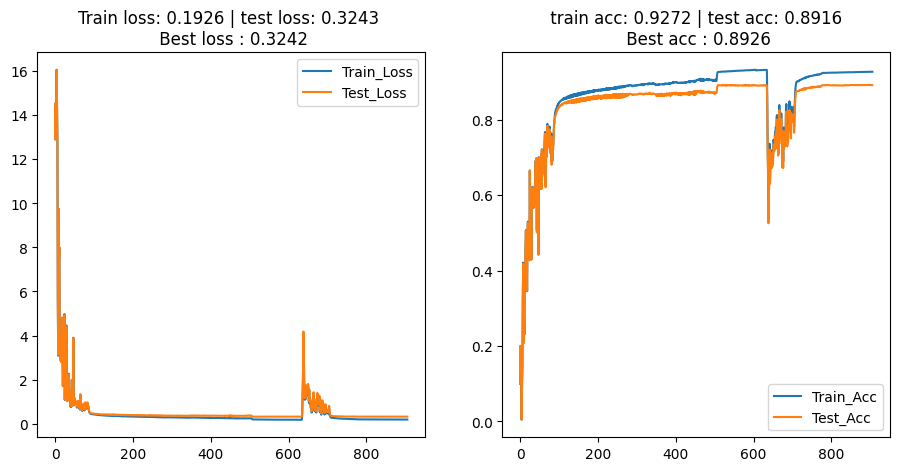

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize =(11,5))
plt.subplot(1,2,1)
plt.title(f"Train loss: {loss:.4f} | test loss: {float(test_loss):.4f} \n Best loss : {float(best_loss):.4f}")
plt.plot(train_loss_list,label="Train_Loss")
plt.plot(test_loss_list,label="Test_Loss")
plt.legend()
plt.subplot(1,2,2)
plt.title(f" train acc: {float(train_acc):.4f} | test acc: {float(test_acc):.4f} \n Best acc : {float(best_acc):.4f}")
plt.plot(train_acc_list,label="Train_Acc")
plt.plot(test_acc_list,label ="Test_Acc")
plt.legend()
plt.show()

Class 0: 0.8351
Class 1: 0.9908
Class 2: 0.7998
Class 3: 0.8963
Class 4: 0.7983
Class 5: 0.9757
Class 6: 0.7559
Class 7: 0.9321
Class 8: 0.9769
Class 9: 0.9636
Class macro avg: 0.8925
Class weighted avg: 0.8925

최저 정확도를 갖는 클래스: Class 6 (0.7559)
최고 정확도를 갖는 클래스: Class 1 (0.9908)


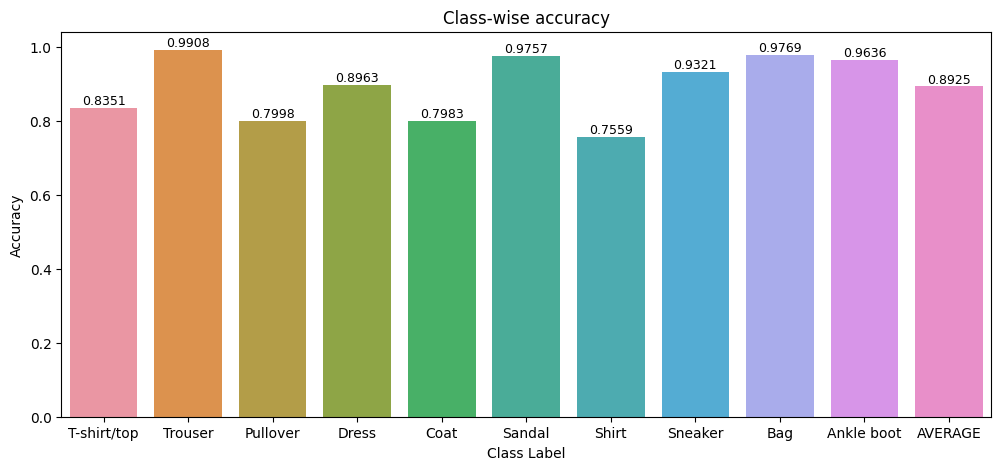

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
    'AVERAGE'
]

# 예측 생성
y_pred = np.argmax(network.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# 분류 보고서 생성
report = classification_report(y_true, y_pred, output_dict=True)


# 클래스별 정확도 추출
class_accuracy = {class_label: metrics['precision'] for class_label, metrics in report.items() if isinstance(metrics, dict)}

for class_label, accuracy in class_accuracy.items():
    print(f'Class {class_label}: {accuracy:.4f}')

# 최저 정확도를 갖는 클래스 찾기
min_accuracy_class = min(class_accuracy, key=class_accuracy.get)
max_accuracy_class = max(class_accuracy, key=class_accuracy.get)

print(f'\n최저 정확도를 갖는 클래스: Class {min_accuracy_class} ({class_accuracy[min_accuracy_class]:.4f})')
print(f'최고 정확도를 갖는 클래스: Class {max_accuracy_class} ({class_accuracy[max_accuracy_class]:.4f})')

# 시각화
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=class_names, y=list(class_accuracy.values())[:11])
# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Class-wise accuracy')
plt.xlabel('Class Label')
plt.ylabel('Accuracy')
plt.show()

Class-wise Metrics:
Class 0: Precision = 0.8351, Recall = 0.8610, F1-score = 0.8479
Class 1: Precision = 0.9908, Recall = 0.9690, F1-score = 0.9798
Class 2: Precision = 0.7998, Recall = 0.8350, F1-score = 0.8170
Class 3: Precision = 0.8963, Recall = 0.8990, F1-score = 0.8977
Class 4: Precision = 0.7983, Recall = 0.8430, F1-score = 0.8200
Class 5: Precision = 0.9757, Recall = 0.9620, F1-score = 0.9688
Class 6: Precision = 0.7559, Recall = 0.6690, F1-score = 0.7098
Class 7: Precision = 0.9321, Recall = 0.9610, F1-score = 0.9463
Class 8: Precision = 0.9769, Recall = 0.9740, F1-score = 0.9755
Class 9: Precision = 0.9636, Recall = 0.9530, F1-score = 0.9583
Class macro avg: Precision = 0.8925, Recall = 0.8926, F1-score = 0.8921
Class weighted avg: Precision = 0.8925, Recall = 0.8926, F1-score = 0.8921


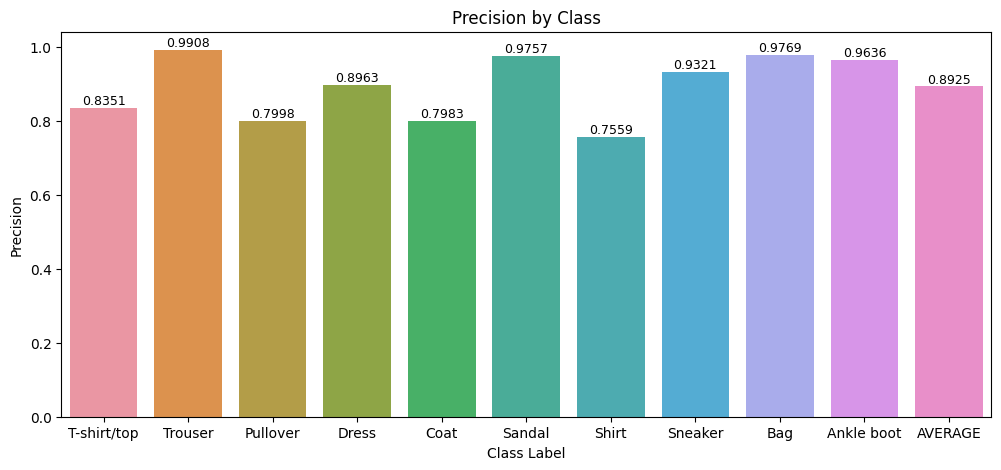

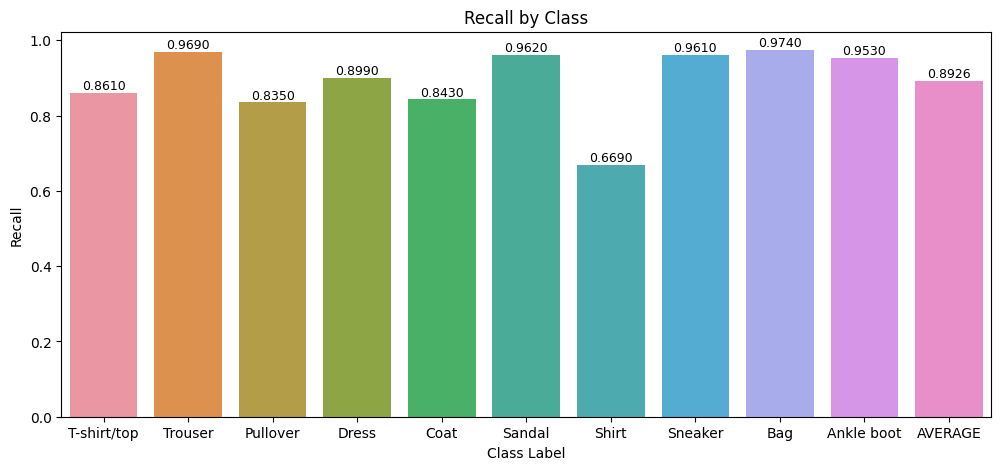

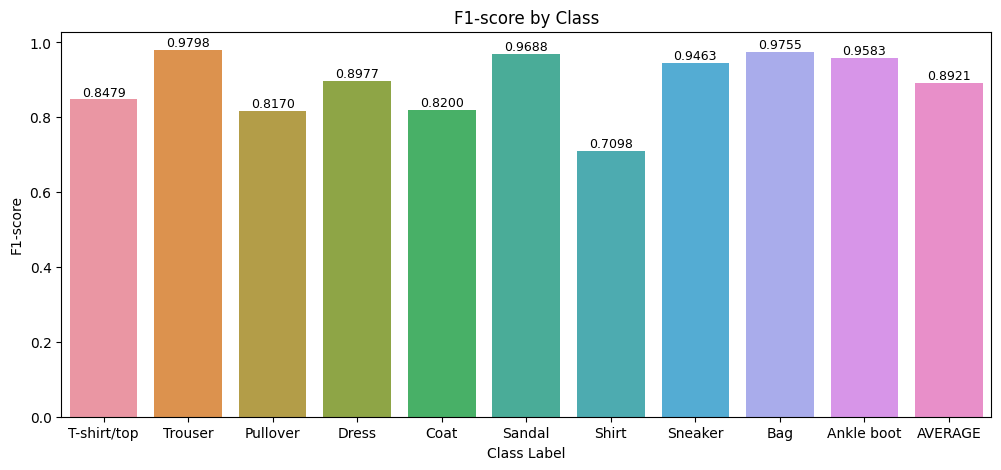

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# classification_report를 이용하여 정확도, 정밀도, 재현율 계산
report = classification_report(y_true, y_pred, output_dict=True)

# 클래스별 정확도, 정밀도, 재현율 추출
class_metrics = {class_label: metrics for class_label, metrics in report.items() if isinstance(metrics, dict)}

# 숫자로 출력
print("Class-wise Metrics:")
for class_label, metrics in class_metrics.items():
    print(f"Class {class_label}: Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}, F1-score = {metrics['f1-score']:.4f}")

# 데이터 프레임으로 변환하여 시각화
import pandas as pd

df_metrics = pd.DataFrame(class_metrics).T[['precision', 'recall', 'f1-score']]
df_metrics = df_metrics.astype(float)  # Ensure the values are of type float

# 그래프 표시
for metric_name in ['precision', 'recall', 'f1-score']:
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(x=class_names, y=df_metrics[metric_name][:-1])
    plt.title(f'{metric_name.capitalize()} by Class')
    plt.xlabel('Class Label')
    plt.ylabel(metric_name.capitalize())

    # Add values on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()



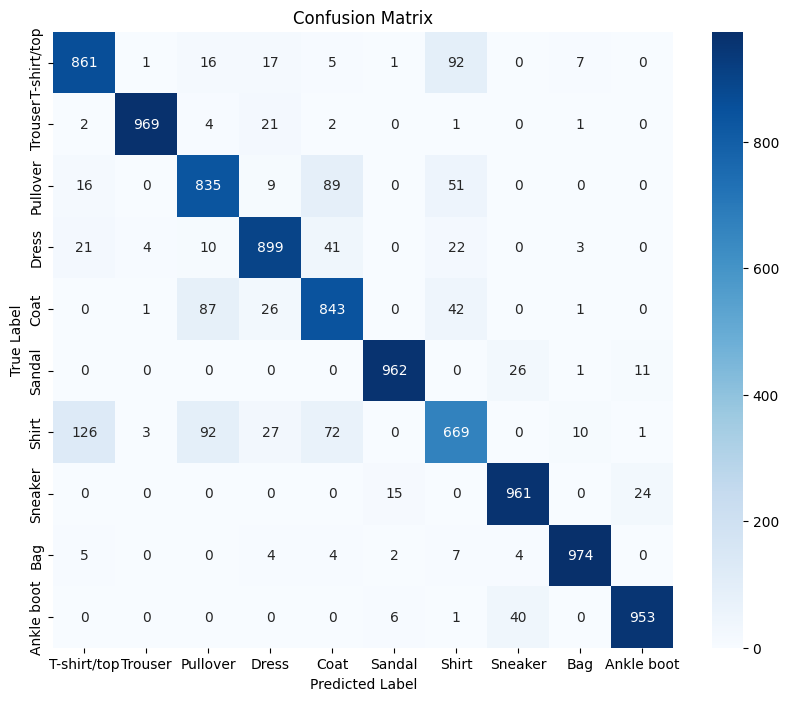

In [42]:
# Confusion Matrix 생성
cm = confusion_matrix(y_true, y_pred)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:10], yticklabels=class_names[:10])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 가중치 불러오기 방법

In [ ]:
# 저장된 모델 불러오기
# 사용 하실때 위치 바꾸셔야 합니다.
with open(f'/content/drive/MyDrive/Basic_DeepLearning/final_project/{hidden_size}.pkl', 'rb') as f:
    network = pickle.load(f)

# 불러온 모델 사용
result = network.accuracy(x_test,y_test)
print(result)

init_learning_rate = 0.002
epochs = 100
warm_up_ep = 0
optimizer = Adam(lr = init_learning_rate)

for epoch in tqdm(range(epochs)):
  # if epoch < warm_up_ep:
  #   learning_rate = round(init_learning_rate*((epoch+1)/warm_up_ep),4)
  #   print(learning_rate)
  # if epoch == 70:
  #   learning_rate = 0.01  
  # if epoch == (epochs-10):
  #   learning_rate = 0.001
  optimizer = Adam(lr = 0.001)
  # 오차역전파법으로 기울기 계산
  grad = network.gradient(x_train, y_train)
  optimizer.update(network.params, grad)

  loss = network.loss(x_train, y_train)
  train_acc = network.accuracy(x_train, y_train)
  #train기록
  train_loss_list.append(loss)
  train_acc_list.append(train_acc)

  #Vaild
  test_loss = network.loss(x_test, y_test)
  test_acc =network.accuracy(x_test,y_test)
  if test_acc > best_acc:
    best_acc = test_acc
    with open(f'C:\Workspace/SNA/JupyterNotebook/basic_deeplearning/final_project/{hidden_size}.pkl', 'wb') as f:
      pickle.dump(network, f)
  if test_loss < best_loss:
    best_loss = test_loss
  #vaild기록
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

  print(f"Train loss: {loss:.4f}| train acc: {float(train_acc):.4f} | test loss: {float(test_loss):.4f}|test acc: {float(test_acc):.4f}")
print("Best acc:",best_acc,"Best loss:",best_loss)
